In [1]:
import tensorflow as tf
import foolbox as fb

import eagerpy as ep
import numpy as np
import matplotlib.pyplot as plt
import pickle
from urllib.request import urlopen

import glob
from PIL import Image
import os
from os import path

In [2]:
# load key value pairs for class detection
imagenet_key_value_pairs = pickle.load(urlopen('https://gist.githubusercontent.com/yrevar/6135f1bd8dcf2e0cc683/raw/d133d61a09d7e5a3b36b8c111a8dd5c4b5d560ee/imagenet1000_clsid_to_human.pkl'))

In [3]:
# preprocess image for foolbox
def preprocess(image):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (224, 224))
    if image.shape[-1] == 1:
        image = tf.image.grayscale_to_rgb(image)
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
    image = image[None, ...]
    return image

In [4]:
# decode predictions number to label
def get_imagenet_label(probs):
  return decode_predictions(probs, top=1)[0][0]

decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

In [5]:
# find label idx of prediction
def find_label_id(label):
    for key, value in imagenet_key_value_pairs.items():
        if label in value:
            return key

In [6]:
# Keras Applications are canned architectures with pre-trained weights.
pretrained_model = tf.keras.applications.MobileNetV2(weights='imagenet')
preprocessing = dict()
bounds = (-1, 1)

# tensorflow model into foolbox model
fmodel = fb.TensorFlowModel(pretrained_model, bounds=bounds, preprocessing=preprocessing)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


In [7]:
pretrained_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

Model accuracy on sample images: 1.0


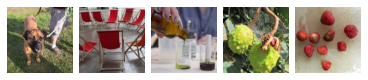

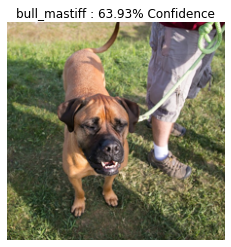

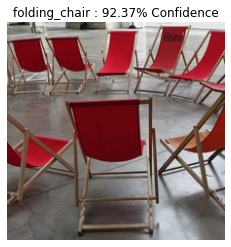

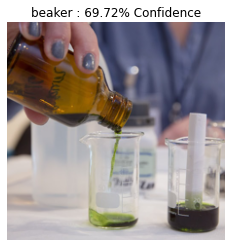

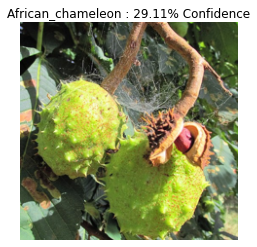

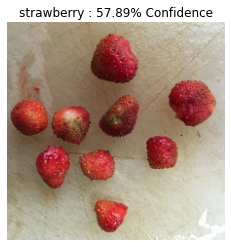

In [8]:
# TEST THAT FOOLBOX WORKS

# optionally transform the bounds of the input space of our model
fmodel = fmodel.transform_bounds((0, 1))

# sample images
images, labels = fb.utils.samples(fmodel, dataset='imagenet', batchsize=5)

# check accuracy on sample images and plot them
accuracy = fb.utils.accuracy(fmodel, images, labels)
print('Model accuracy on sample images:', accuracy)
fb.plot.images(images)
plt.show()
plt.close()

# Predict with pre-trained model
for x in images:
    image = np.expand_dims(x, axis=0)
    image_probs = pretrained_model.predict(image)
    plt.figure()
    plt.imshow(x)  # To change [-1, 1] to [0,1]?
    _, image_class, class_confidence = get_imagenet_label(image_probs)
    plt.title('{} : {:.2f}% Confidence'.format(image_class, class_confidence*100))
    plt.axis('off')
    #plt.close()

In [9]:
#Creates list of paths to images in the dataset.
COCO_original = glob.glob('datasets/coco_original/data/*.jpg')
COCO_224 = glob.glob('datasets/coco_224/data/*.jpg')

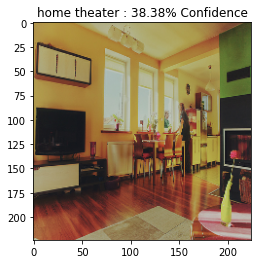

Model accuracy before perturbation: 1.0
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
Model accuracy after perturbation: [1.]


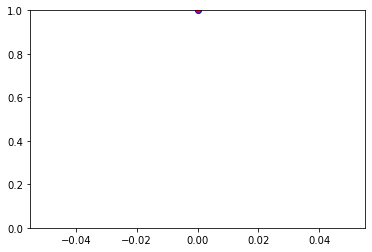

In [10]:
### Run crafting on one image and visualize the results

def show_image_with_class(image, image_class, class_confidence):
    plt.figure()
    plt.imshow(image[0] * 0.5 + 0.5)  # To change [-1, 1] to [0,1]
    plt.title('{} : {:.2f}% Confidence'.format(image_class, class_confidence*100))
    plt.show()    

def preprocess_image(image):
    image_raw = tf.io.read_file(fname)
    image = tf.image.decode_image(image_raw)
    image = preprocess(image)
    return image

def convert_to_tensor(image, label): 
    #print('Min values in image-array: ' + str(np.amin(image)) + ' Max values in image-array: ' + str(np.amax(image)))
    image = (image + 1.0)/2 # shift from [-1,1] to [0,1] with 0.5 mean
    image_tensor = tf.convert_to_tensor(image, dtype=tf.float32)
    label_tensor = tf.convert_to_tensor([label], dtype=tf.int32) # needs to be list
    #print('Min values in image-array: ' + str(np.amin(image)) + ' Max values in image-array: ' + str(np.amax(image)))
    return image_tensor, label_tensor

def get_class_data(probs):
    _, image_class, class_confidence = get_imagenet_label(probs)
    image_class = image_class.replace("_", " ")
    image_label_id = find_label_id(image_class)
    return image_label_id, image_class, class_confidence

def test_foolbox(image_tensor, label_tensor):
    # Testing that conversion works
    #fb.plot.images(image_tensor, scale=4.) messes plotting of the
    accuracy = fb.utils.accuracy(fmodel, image_tensor, label_tensor)
    print('Model accuracy before perturbation:', accuracy)
    plt.show

def craft_adversarial(image, label):
    epsilons = [0]
    attack = fb.attacks.L2CarliniWagnerAttack(steps=100, binary_search_steps=5, initial_const=0.01,stepsize=0.001, abort_early=True)
    print(attack)
    # use eagerpy tensors own images
    images = ep.astensor(image)
    labels = ep.astensor(label)
    # raw = The raw adversarial examples. --> depends on attack
    # clipped = The clipped adversarial examples --> guaranteed to not be perturbed more than epsilon.
    # is_adv = boolean for each sample image. True if misclassified and within the epsilon balls around the clean sample.
    raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=epsilons)
    # show accuracy vs epsilons
    robust_accuracy = 1 - is_adv.float32().mean(axis=-1)
    plt.plot(epsilons, robust_accuracy.numpy(), color='blue', linestyle='solid', marker='o', markerfacecolor='red')
    plt.ylim([0, 1])
    print('Model accuracy after perturbation:', robust_accuracy.numpy())
    plt.show()
    return clipped

for fname in COCO_original:
    
    #Preprocess
    image = preprocess_image(fname)
    image_probs = pretrained_model.predict(image)
    image_label_id, image_class, class_confidence = get_class_data(image_probs)
    show_image_with_class(image, image_class, class_confidence)
    
    image_tensor, label_tensor = convert_to_tensor(image, image_label_id)
    test_foolbox(image_tensor, label_tensor)
    
    #Craft Adversarial
    clipped = craft_adversarial(image_tensor, label_tensor)
    
    #Visualize Original Image, Perturbation and Adversarial Image
    break

tf.Tensor(28.63313, shape=(), dtype=float32)


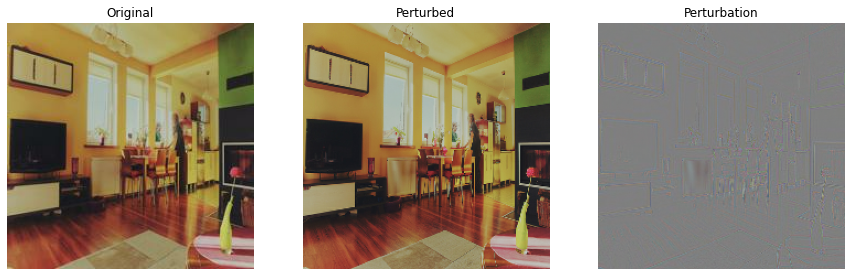

In [11]:
def plot_images(im1,im2):
    fig = plt.figure(figsize=(15,15))
    ax = fig.add_subplot(1, 3, 1)
    imgplot = plt.imshow(im1)
    ax.set_title('Original')
    plt.axis('off')
    ax = fig.add_subplot(1, 3, 2)
    imgplot = plt.imshow(im2)
    ax.set_title('Perturbed')
    plt.axis('off')
    
    ax = fig.add_subplot(1, 3, 3)
    imgplot = plt.imshow((im2-im1)* 0.5 + 0.5)
    ax.set_title('Perturbation')
    plt.axis('off')
    plt.show()
    
    

def calculate_psnr(im1, im2):
    im1 = tf.io.read_file(COCO_224[0])
    im1 = tf.image.decode_jpeg(im1, channels=3)
    im1 = tf.image.convert_image_dtype(im1, tf.float32)
    im2 = tf.convert_to_tensor(tf.squeeze(im2.numpy()))
    psnr1 = tf.image.psnr(im1, im2, max_val=1.0)
    print(psnr1)
    plot_images(im1,im2)
    
    
for ae in range(len(clipped)):
    calculate_psnr(COCO_224[0], clipped[ae])


Counter: 1
Adversarial file exists
Counter: 2
Adversarial file exists
Counter: 3
Adversarial file exists
Counter: 4
Adversarial file exists
Counter: 5
Adversarial file exists
Counter: 6
Adversarial file exists
Counter: 7
Adversarial file exists
Counter: 8
Adversarial file exists
Counter: 9
Adversarial file exists
Counter: 10
Adversarial file exists
Counter: 11
Adversarial file exists
Counter: 12
Adversarial file exists
Counter: 13
Adversarial file exists
Counter: 14
Adversarial file exists
Counter: 15
Adversarial file exists
Counter: 16
Adversarial file exists
Counter: 17
Adversarial file exists
Counter: 18
Adversarial file exists
Counter: 19
Adversarial file exists
Counter: 20
Adversarial file exists
Counter: 21
Adversarial file exists
Counter: 22
Adversarial file exists
Counter: 23
Adversarial file exists
Counter: 24
Adversarial file exists
Counter: 25
Adversarial file exists
Counter: 26
Adversarial file exists
Counter: 27
Adversarial file exists
Counter: 28
Adversarial file exists
C

Adversarial file exists
Counter: 226
Adversarial file exists
Counter: 227
Adversarial file exists
Counter: 228
Adversarial file exists
Counter: 229
Adversarial file exists
Counter: 230
Adversarial file exists
Counter: 231
Adversarial file exists
Counter: 232
Adversarial file exists
Counter: 233
Adversarial file exists
Counter: 234
Adversarial file exists
Counter: 235
Adversarial file exists
Counter: 236
Adversarial file exists
Counter: 237
Adversarial file exists
Counter: 238
Adversarial file exists
Counter: 239
Adversarial file exists
Counter: 240
Adversarial file exists
Counter: 241
Adversarial file exists
Counter: 242
Adversarial file exists
Counter: 243
Adversarial file exists
Counter: 244
Adversarial file exists
Counter: 245
Adversarial file exists
Counter: 246
Adversarial file exists
Counter: 247
Adversarial file exists
Counter: 248
Adversarial file exists
Counter: 249
Adversarial file exists
Counter: 250
Adversarial file exists
Counter: 251
Adversarial file exists
Counter: 252
A

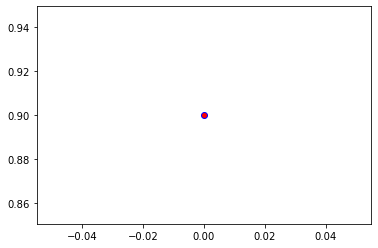

Counter: 311
000000358427 937 = broccoli
000000358525 508 = computer keyboard
000000358923 518 = crash helmet
000000359135 386 = African elephant
000000359219 962 = meat loaf
000000359540 981 = ballplayer
000000359677 484 = catamaran
000000359781 9 = ostrich
000000359833 952 = fig
000000359855 621 = lawn mower
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 1.0
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>)
Model accuracy after perturbation: [1.]


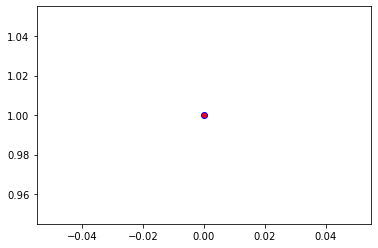

Counter: 312
000000359937 705 = passenger car
000000360097 408 = amphibian
000000360137 703 = park bench
000000360325 355 = llama
000000360393 963 = pizza
000000360564 534 = washer
000000360661 354 = Arabian camel
000000360943 539 = doormat
000000360951 664 = monitor
000000360960 879 = umbrella
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 0.8999999761581421
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.1], dtype=float32)>)
Model accuracy after perturbation: [0.9]


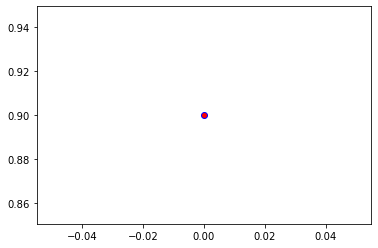

Counter: 313
000000361103 707 = pay-phone
000000361142 498 = palace
000000361147 752 = racket
000000361180 294 = brown bear
000000361238 963 = pizza
000000361268 339 = sorrel
000000361506 324 = cab
000000361551 537 = dogsled
000000361571 208 = Labrador retriever
000000361586 762 = restaurant
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 0.800000011920929
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.2], dtype=float32)>)
Model accuracy after perturbation: [0.8]


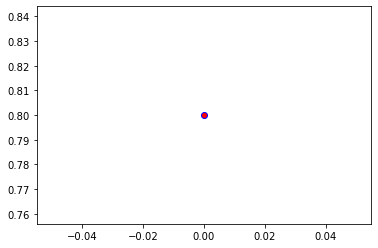

Counter: 314
000000361621 285 = Egyptian cat
000000361730 978 = seashore
000000361919 140 = alp
000000362434 850 = teddy
000000362520 408 = amphibian
000000362682 654 = minibus
000000362716 752 = racket
000000363072 565 = freight car
000000363188 467 = butcher shop
000000363207 532 = dining table
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 0.8999999761581421
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.1], dtype=float32)>)
Model accuracy after perturbation: [0.9]


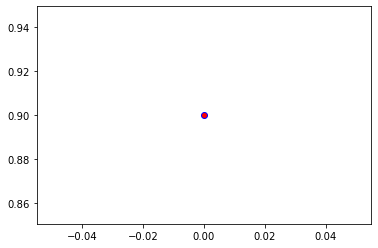

Counter: 315
000000363461 526 = desk
000000363666 461 = plate
000000363784 435 = bathtub
000000363840 620 = laptop
000000363875 670 = motor scooter
000000364102 416 = balance beam
000000364126 693 = paddle
000000364166 340 = zebra
000000364297 620 = laptop
000000364322 5 = ram
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 0.800000011920929
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.2], dtype=float32)>)
Model accuracy after perturbation: [0.8]


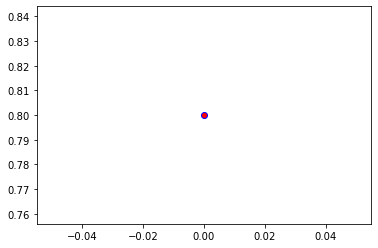

Counter: 316
000000364557 562 = fountain
000000364587 547 = electric locomotive
000000364636 243 = bull mastiff
000000364884 450 = bobsled
000000365095 805 = soccer ball
000000365098 472 = canoe
000000365207 475 = car mirror
000000365208 879 = umbrella
000000365385 647 = measuring cup
000000365387 861 = toilet seat
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 1.0
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>)
Model accuracy after perturbation: [1.]


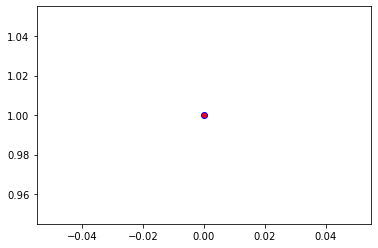

Counter: 317
000000365521 248 = ski
000000365642 655 = miniskirt
000000365655 609 = jeep
000000365745 569 = garbage truck
000000365766 651 = microwave
000000365886 487 = cellular telephone
000000366141 598 = home theater
000000366178 450 = bobsled
000000366199 112 = conch
000000366225 527 = desktop computer
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 0.8999999761581421
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.1], dtype=float32)>)
Model accuracy after perturbation: [0.9]


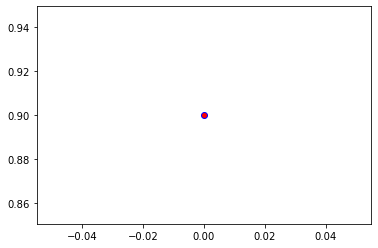

Counter: 318
000000366611 180 = American Staffordshire terrier
000000366711 950 = orange
000000366884 799 = sliding door
000000367082 234 = Rottweiler
000000367095 526 = desk
000000367195 263 = Pembroke
000000367228 879 = umbrella
000000367386 831 = studio couch
000000367569 598 = home theater
000000367680 654 = minibus
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 1.0
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>)
Model accuracy after perturbation: [1.]


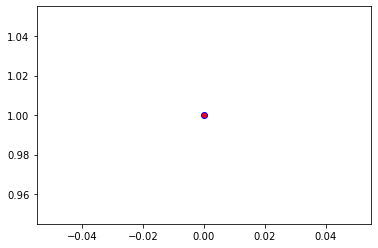

Counter: 319
000000367818 339 = sorrel
000000368038 547 = electric locomotive
000000368212 929 = ice lolly
000000368294 410 = apiary
000000368335 354 = Arabian camel
000000368456 565 = freight car
000000368684 851 = television
000000368752 461 = plate
000000368900 423 = barber chair
000000368940 896 = washbasin
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 0.8999999761581421
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.1], dtype=float32)>)
Model accuracy after perturbation: [0.9]


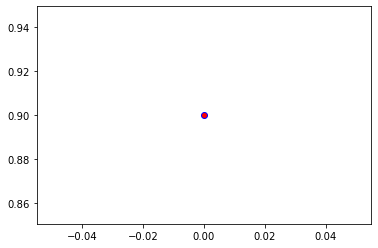

Counter: 320
000000368961 386 = African elephant
000000368982 784 = screwdriver
000000369037 385 = Indian elephant
000000369081 339 = sorrel
000000369310 981 = ballplayer
000000369323 752 = racket
000000369370 924 = guacamole
000000369442 54 = hog
000000369503 534 = dishwasher
000000369541 232 = Border collie
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 0.8999999761581421
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.1], dtype=float32)>)
Model accuracy after perturbation: [0.9]


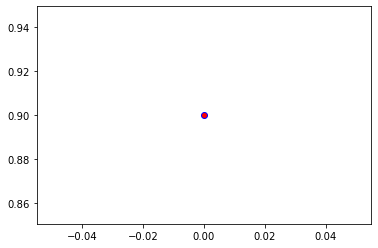

Counter: 321
000000369675 705 = passenger car
000000369751 704 = parking meter
000000369757 415 = bakery
000000369771 928 = ice cream
000000369812 919 = street sign
000000370042 775 = sarong
000000370208 704 = parking meter
000000370270 454 = bookshop
000000370375 981 = ballplayer
000000370478 742 = printer
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 1.0
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>)
Model accuracy after perturbation: [1.]


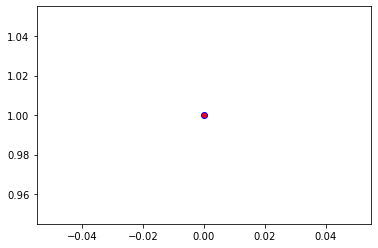

Counter: 322
000000370486 808 = sombrero
000000370677 582 = grocery store
000000370711 865 = toyshop
000000370813 920 = traffic light
000000370818 648 = medicine chest
000000370900 850 = teddy
000000370999 635 = magnetic compass
000000371042 752 = racket
000000371472 953 = pineapple
000000371529 861 = toilet seat
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 1.0
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>)
Model accuracy after perturbation: [1.]


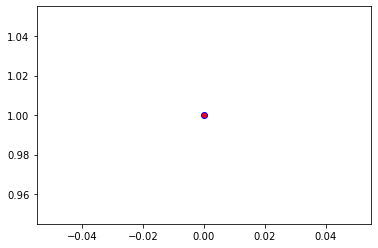

Counter: 323
000000371552 805 = soccer ball
000000371677 851 = television
000000371699 624 = library
000000371749 217 = English springer
000000372203 843 = swing
000000372260 409 = analog clock
000000372307 73 = barn
000000372317 555 = fire engine
000000372349 801 = snorkel
000000372466 673 = mouse
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 0.8999999761581421
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.1], dtype=float32)>)
Model accuracy after perturbation: [0.9]


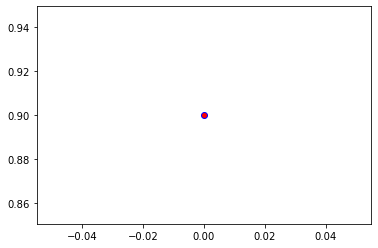

Counter: 324
000000372577 752 = racket
000000372718 883 = vase
000000372819 162 = beagle
000000373315 248 = ski
000000373353 829 = streetcar
000000373382 752 = racket
000000373705 862 = torch
000000374052 447 = binoculars
000000374083 891 = waffle iron
000000374369 248 = ski
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 0.800000011920929
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.2], dtype=float32)>)
Model accuracy after perturbation: [0.8]


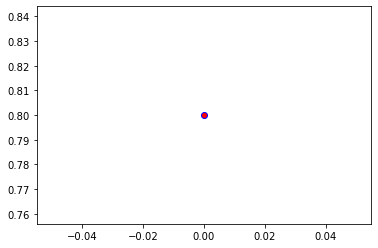

Counter: 325
000000374545 557 = flagpole
000000374551 13 = junco
000000374727 919 = street sign
000000374982 963 = pizza
000000375015 295 = American black bear
000000375078 512 = corkscrew
000000375278 223 = schipperke
000000375430 928 = ice cream
000000375469 148 = killer whale
000000375493 552 = feather boa
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 1.0
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>)
Model accuracy after perturbation: [1.]


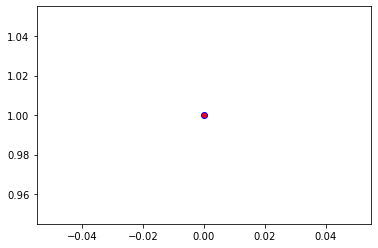

Counter: 326
000000375763 5 = ram
000000376093 589 = hand blower
000000376112 248 = ski
000000376206 693 = paddle
000000376264 131 = rule
000000376278 340 = zebra
000000376284 412 = ashcan
000000376307 954 = banana
000000376310 495 = china cabinet
000000376322 762 = restaurant
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 0.699999988079071
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.3], dtype=float32)>)
Model accuracy after perturbation: [0.7]


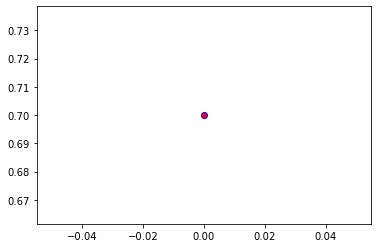

Counter: 327
000000376365 818 = spotlight
000000376442 999 = toilet tissue
000000376478 883 = vase
000000376625 829 = streetcar
000000376856 442 = bell cote
000000376900 752 = racket
000000377000 283 = Persian cat
000000377113 248 = ski
000000377239 879 = umbrella
000000377368 533 = dishrag
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 0.8999999761581421
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.1], dtype=float32)>)
Model accuracy after perturbation: [0.9]


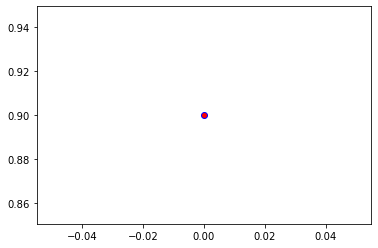

Counter: 328
000000377393 639 = tank
000000377486 346 = water buffalo
000000377497 340 = zebra
000000377575 266 = miniature poodle
000000377588 981 = ballplayer
000000377635 421 = bannister
000000377670 726 = plane
000000377723 874 = trolleybus
000000377814 931 = bagel
000000377882 489 = chainlink fence
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 0.8999999761581421
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.1], dtype=float32)>)
Model accuracy after perturbation: [0.9]


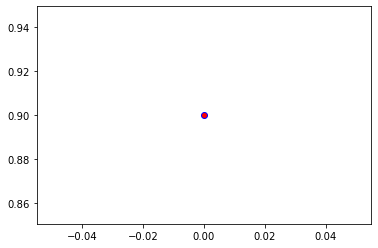

Counter: 329
000000377946 407 = ambulance
000000378099 673 = mouse
000000378116 148 = killer whale
000000378139 975 = lakeside
000000378244 802 = snowmobile
000000378284 963 = pizza
000000378453 340 = zebra
000000378454 146 = albatross
000000378515 582 = grocery store
000000378605 931 = bagel
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 1.0
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>)
Model accuracy after perturbation: [1.]


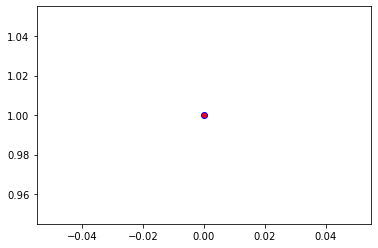

Counter: 330
000000378673 880 = unicycle
000000378873 949 = strawberry
000000379332 752 = racket
000000379441 453 = bookcase
000000379453 404 = airliner
000000379476 497 = church
000000379533 340 = zebra
000000379800 547 = electric locomotive
000000379842 709 = pencil box
000000380203 5 = ram
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 0.8999999761581421
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.1], dtype=float32)>)
Model accuracy after perturbation: [0.9]


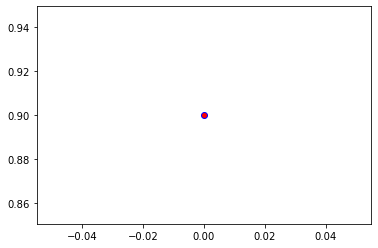

Counter: 331
000000380706 612 = jinrikisha
000000380711 143 = oystercatcher
000000380913 575 = golfcart
000000381360 148 = killer whale
000000381587 532 = dining table
000000381639 646 = maze
000000381971 603 = horse cart
000000382009 752 = racket
000000382030 903 = wig
000000382088 37 = ox
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 0.8999999761581421
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.1], dtype=float32)>)
Model accuracy after perturbation: [0.9]


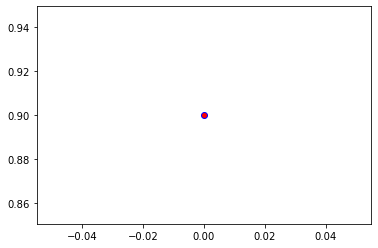

Counter: 332
000000382111 603 = horse cart
000000382122 497 = church
000000382125 470 = candle
000000382696 881 = upright
000000382734 648 = medicine chest
000000382743 701 = parachute
000000383289 880 = unicycle
000000383337 410 = apiary
000000383339 978 = seashore
000000383384 981 = ballplayer
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 1.0
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>)
Model accuracy after perturbation: [1.]


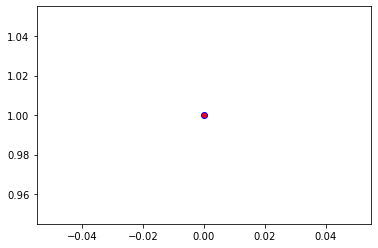

Counter: 333
000000383386 850 = teddy
000000383443 435 = tub
000000383606 896 = washbasin
000000383621 895 = warplane
000000383676 288 = leopard
000000383838 470 = candle
000000383842 617 = lab coat
000000383921 385 = Indian elephant
000000384136 589 = hand blower
000000384350 318 = wing
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 0.800000011920929
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.2], dtype=float32)>)
Model accuracy after perturbation: [0.8]


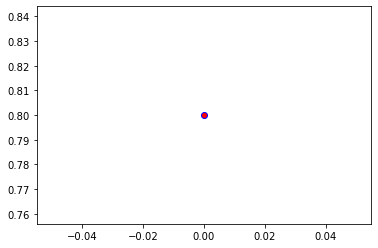

Counter: 334
000000384468 385 = Indian elephant
000000384513 537 = dogsled
000000384527 532 = dining table
000000384616 358 = pole
000000384651 619 = lampshade
000000384661 827 = stove
000000384666 248 = ski
000000384670 752 = racket
000000384808 896 = washbasin
000000384850 794 = shower curtain
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 0.800000011920929
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.2], dtype=float32)>)
Model accuracy after perturbation: [0.8]


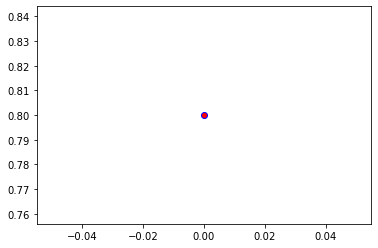

Counter: 335
000000384949 713 = pier
000000385029 910 = wooden spoon
000000385190 480 = cash machine
000000385205 281 = tabby
000000385719 527 = desktop computer
000000385997 471 = cannon
000000386134 962 = meat loaf
000000386210 28 = pot
000000386277 951 = lemon
000000386352 752 = racket
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 0.800000011920929
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.2], dtype=float32)>)
Model accuracy after perturbation: [0.8]


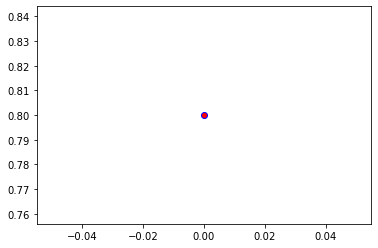

Counter: 336
000000386457 519 = crate
000000386879 752 = racket
000000386912 454 = bookshop
000000387098 526 = desk
000000387148 649 = megalith
000000387383 750 = quilt
000000387387 779 = school bus
000000387916 140 = alp
000000388056 981 = ballplayer
000000388215 752 = racket
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 0.8999999761581421
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.1], dtype=float32)>)
Model accuracy after perturbation: [0.9]


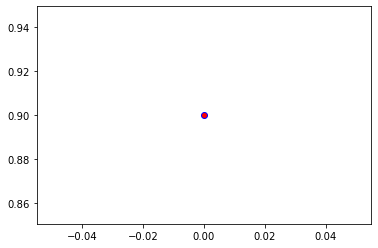

Counter: 337
000000388258 444 = bicycle-built-for-two
000000388846 830 = stretcher
000000388903 433 = bathing cap
000000388927 761 = remote control
000000389109 926 = hot pot
000000389197 450 = bobsled
000000389315 692 = packet
000000389316 386 = African elephant
000000389381 939 = zucchini
000000389451 978 = seashore
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 1.0
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>)
Model accuracy after perturbation: [1.]


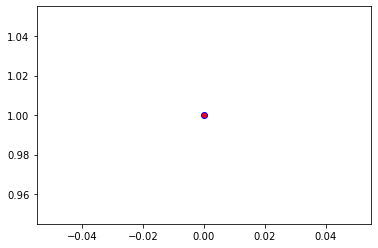

Counter: 338
000000389532 864 = wreck
000000389566 562 = fountain
000000389684 874 = trolleybus
000000389804 861 = toilet seat
000000389812 955 = jackfruit
000000389933 159 = Rhodesian ridgeback
000000390246 842 = swimming trunks
000000390301 562 = fountain
000000390555 715 = pickelhaube
000000390826 388 = giant panda
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 0.8999999761581421
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.1], dtype=float32)>)
Model accuracy after perturbation: [0.9]


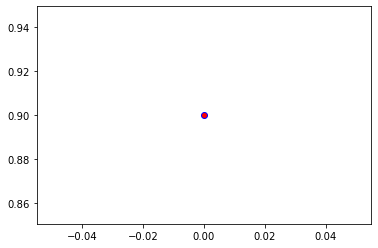

Counter: 339
000000390902 722 = ping-pong ball
000000391140 731 = plunger
000000391144 386 = African elephant
000000391290 805 = soccer ball
000000391375 884 = vault
000000391648 442 = bell cote
000000391722 470 = candle
000000392228 892 = wall clock
000000392481 895 = warplane
000000392722 829 = streetcar
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 1.0
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>)
Model accuracy after perturbation: [1.]


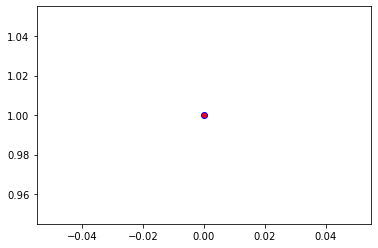

Counter: 340
000000392818 156 = Blenheim spaniel
000000392933 133 = bittern
000000393014 934 = hotdog
000000393056 814 = speedboat
000000393093 829 = streetcar
000000393115 428 = barrow
000000393226 864 = tow truck
000000393282 355 = llama
000000393469 248 = ski
000000393569 648 = medicine chest
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 0.8999999761581421
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.1], dtype=float32)>)
Model accuracy after perturbation: [0.9]


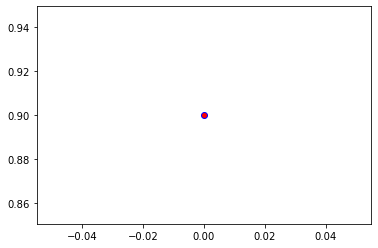

Counter: 341
000000393838 544 = Dutch oven
000000394199 665 = moped
000000394206 612 = jinrikisha
000000394275 874 = trolleybus
000000394328 861 = toilet seat
000000394510 775 = sarong
000000394559 752 = racket
000000394611 9 = ostrich
000000394677 513 = cornet
000000394940 461 = plate
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 0.8999999761581421
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.1], dtype=float32)>)
Model accuracy after perturbation: [0.9]


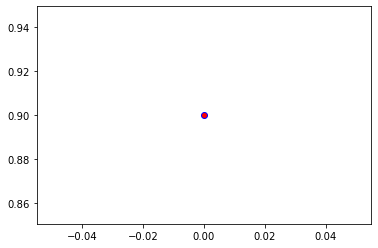

Counter: 342
000000395180 500 = cliff
000000395343 883 = vase
000000395388 634 = lumbermill
000000395575 449 = boathouse
000000395633 536 = dock
000000395701 598 = home theater
000000395801 880 = unicycle
000000395903 460 = breakwater
000000396200 880 = unicycle
000000396205 347 = bison
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 0.8999999761581421
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.1], dtype=float32)>)
Model accuracy after perturbation: [0.9]


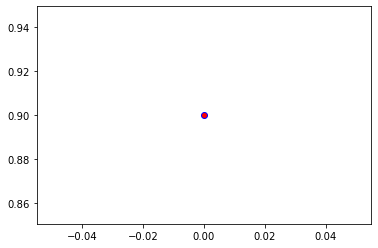

Counter: 343
000000396274 28 = pot
000000396338 324 = cab
000000396518 428 = barrow
000000396526 905 = window shade
000000396568 565 = freight car
000000396580 449 = boathouse
000000396729 662 = modem
000000396863 246 = Great Dane
000000396903 407 = ambulance
000000397133 788 = shoe shop
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 0.800000011920929
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.2], dtype=float32)>)
Model accuracy after perturbation: [0.8]


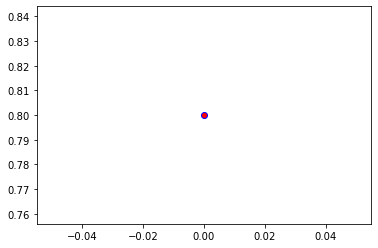

Counter: 344
000000397279 752 = racket
000000397303 788 = shoe shop
000000397327 896 = washbasin
000000397351 582 = grocery store
000000397354 521 = Crock Pot
000000397639 5 = ram
000000397681 950 = orange
000000398028 981 = ballplayer
000000398203 805 = soccer ball
000000398237 417 = balloon
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 0.8999999761581421
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.1], dtype=float32)>)
Model accuracy after perturbation: [0.9]


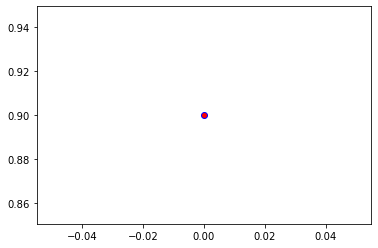

Counter: 345
000000398377 608 = jean
000000398438 112 = conch
000000398652 582 = grocery store
000000398742 768 = rugby ball
000000398810 223 = schipperke
000000398905 819 = stage
000000399205 929 = ice lolly
000000399296 909 = wok
000000399462 805 = soccer ball
000000399560 285 = Egyptian cat
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 1.0
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>)
Model accuracy after perturbation: [1.]


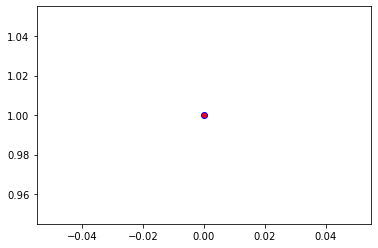

Counter: 346
000000399655 195 = Boston bull
000000399764 37 = ox
000000400044 248 = ski
000000400082 934 = hotdog
000000400161 626 = lighter
000000400367 324 = cab
000000400573 929 = ice lolly
000000400794 843 = swing
000000400803 625 = lifeboat
000000400815 573 = go-kart
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 0.699999988079071
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.3], dtype=float32)>)
Model accuracy after perturbation: [0.7]


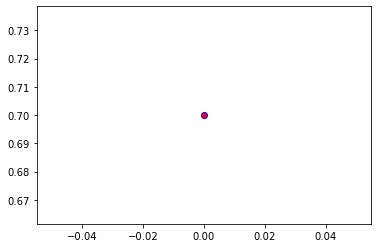

Counter: 347
000000400922 919 = street sign
000000401244 805 = soccer ball
000000401250 134 = crane
000000401446 879 = umbrella
000000401862 555 = fire engine
000000401991 202 = soft-coated wheaten terrier
000000402096 778 = scale
000000402118 248 = ski
000000402334 497 = church
000000402346 41 = hip
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 0.699999988079071
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.3], dtype=float32)>)
Model accuracy after perturbation: [0.7]


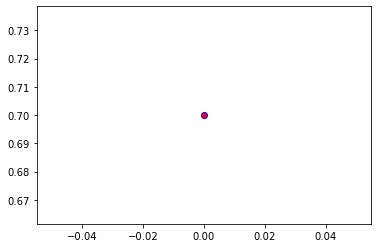

Counter: 348
000000402433 963 = pizza
000000402473 285 = Egyptian cat
000000402519 95 = jacamar
000000402615 981 = ballplayer
000000402720 762 = restaurant
000000402765 761 = remote control
000000402774 879 = umbrella
000000402783 461 = plate
000000402992 347 = bison
000000403122 752 = racket
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 0.8999999761581421
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.1], dtype=float32)>)
Model accuracy after perturbation: [0.9]


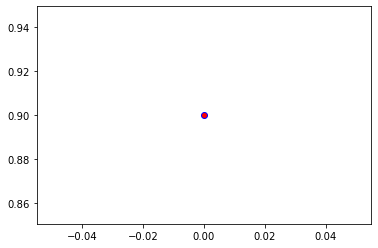

Counter: 349
000000403353 846 = table lamp
000000403385 435 = bathtub
000000403565 671 = mountain bike
000000403584 978 = seashore
000000403817 527 = desktop computer
000000404128 895 = warplane
000000404191 648 = medicine chest
000000404249 596 = hatchet
000000404479 404 = airliner
000000404484 237 = miniature pinscher
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 1.0
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>)
Model accuracy after perturbation: [1.]


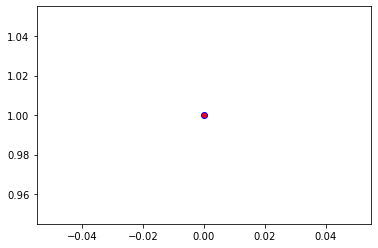

Counter: 350
000000404534 424 = barbershop
000000404568 146 = albatross
000000404601 919 = street sign
000000404678 892 = wall clock
000000404805 445 = bikini
000000404839 456 = bow
000000404922 655 = miniskirt
000000404923 981 = ballplayer
000000405195 415 = bakery
000000405205 874 = trolleybus
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 1.0
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>)
Model accuracy after perturbation: [1.]


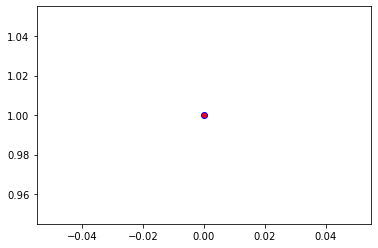

Counter: 351
000000405249 470 = candle
000000405279 975 = lakeside
000000405306 281 = tabby
000000405432 499 = cleaver
000000405691 966 = red wine
000000405970 598 = home theater
000000405972 385 = Indian elephant
000000406129 752 = racket
000000406417 608 = jean
000000406570 66 = corn
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 0.8999999761581421
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.1], dtype=float32)>)
Model accuracy after perturbation: [0.9]


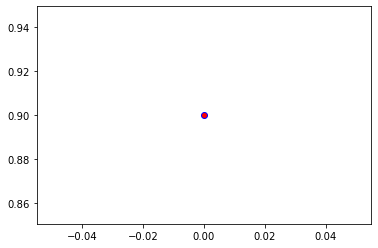

Counter: 352
000000406611 537 = dogsled
000000406997 5 = ram
000000407002 248 = ski
000000407083 785 = seat belt
000000407298 61 = boa constrictor
000000407403 899 = water jug
000000407518 85 = quail
000000407524 937 = broccoli
000000407574 954 = banana
000000407614 651 = microwave
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 0.800000011920929
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.2], dtype=float32)>)
Model accuracy after perturbation: [0.8]


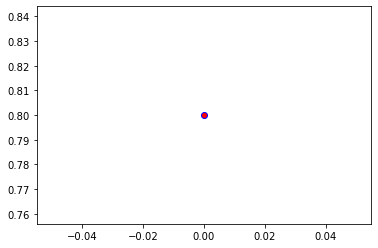

Counter: 353
000000407646 752 = racket
000000407650 140 = alp
000000407825 859 = toaster
000000407868 701 = parachute
000000407943 461 = breastplate
000000407960 285 = Egyptian cat
000000408112 403 = aircraft carrier
000000408120 671 = mountain bike
000000408696 424 = barbershop
000000408774 981 = ballplayer
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 0.8999999761581421
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.1], dtype=float32)>)
Model accuracy after perturbation: [0.9]


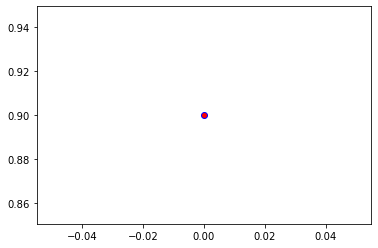

Counter: 354
000000408830 670 = motor scooter
000000409198 981 = ballplayer
000000409211 752 = racket
000000409268 850 = teddy
000000409358 896 = washbasin
000000409424 954 = banana
000000409475 248 = ski
000000409542 409 = analog clock
000000409630 673 = mouse
000000409867 905 = window shade
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 0.8999999761581421
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.1], dtype=float32)>)
Model accuracy after perturbation: [0.9]


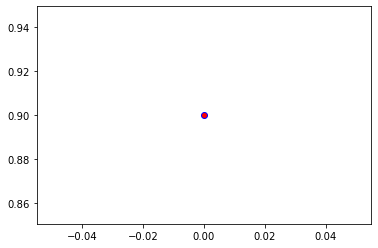

Counter: 355
000000410221 318 = wing
000000410428 5 = ram
000000410456 977 = sandbar
000000410487 827 = stove
000000410496 752 = racket
000000410510 248 = ski
000000410612 554 = fireboat
000000410650 752 = racket
000000410712 920 = traffic light
000000410735 926 = hot pot
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 0.699999988079071
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.3], dtype=float32)>)
Model accuracy after perturbation: [0.7]


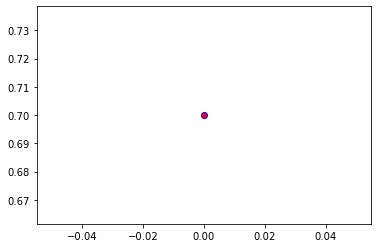

Counter: 356
000000410878 665 = moped
000000410880 267 = standard poodle
000000410934 938 = cauliflower
000000411530 248 = ski
000000411665 248 = Eskimo dog
000000411754 691 = oxygen mask
000000411774 740 = power drill
000000411817 886 = vending machine
000000411938 444 = bicycle-built-for-two
000000411953 546 = electric guitar
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 0.8999999761581421
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.1], dtype=float32)>)
Model accuracy after perturbation: [0.9]


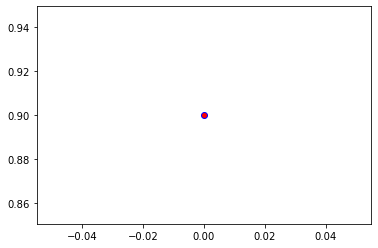

Counter: 357
000000412240 357 = mink
000000412286 752 = racket
000000412362 667 = mortarboard
000000412531 704 = parking meter
000000412887 355 = llama
000000412894 920 = traffic light
000000413247 526 = desk
000000413395 264 = Cardigan
000000413404 703 = park bench
000000413552 435 = tub
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 0.8999999761581421
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.1], dtype=float32)>)
Model accuracy after perturbation: [0.9]


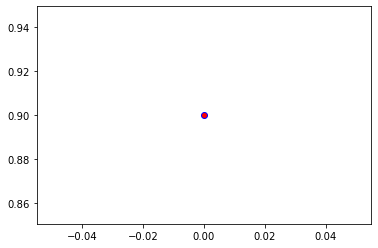

Counter: 358
000000413689 523 = crutch
000000414034 515 = cowboy hat
000000414133 637 = mailbox
000000414170 248 = ski
000000414261 297 = sloth bear
000000414340 663 = monastery
000000414385 484 = catamaran
000000414510 675 = moving van
000000414638 965 = burrito
000000414673 645 = maypole
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 0.8999999761581421
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.1], dtype=float32)>)
Model accuracy after perturbation: [0.9]


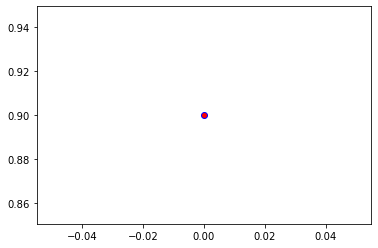

Counter: 359
000000414676 442 = bell cote
000000414795 385 = Indian elephant
000000415194 651 = microwave
000000415238 406 = altar
000000415536 829 = streetcar
000000415716 526 = desk
000000415727 593 = harp
000000415741 894 = wardrobe
000000415748 385 = Indian elephant
000000415882 831 = studio couch
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 0.8999999761581421
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.1], dtype=float32)>)
Model accuracy after perturbation: [0.9]


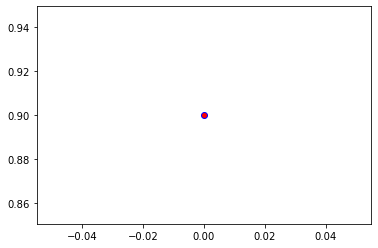

Counter: 360
000000415990 690 = oxcart
000000416104 450 = bobsled
000000416170 904 = window screen
000000416256 965 = burrito
000000416269 547 = electric locomotive
000000416330 284 = Siamese cat
000000416343 747 = punching bag
000000416451 420 = banjo
000000416534 765 = rocking chair
000000416745 648 = medicine chest
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 1.0
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>)
Model accuracy after perturbation: [1.]


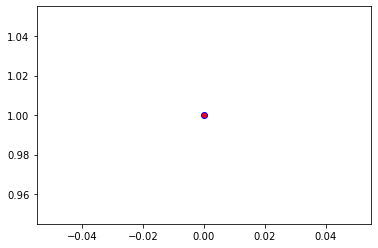

Counter: 361
000000416758 37 = ox
000000416837 350 = ibex
000000416885 572 = goblet
000000416991 829 = streetcar
000000417043 489 = chainlink fence
000000417085 354 = Arabian camel
000000417249 424 = barbershop
000000417285 965 = burrito
000000417465 295 = American black bear
000000417608 964 = potpie
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 0.8999999761581421
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.1], dtype=float32)>)
Model accuracy after perturbation: [0.9]


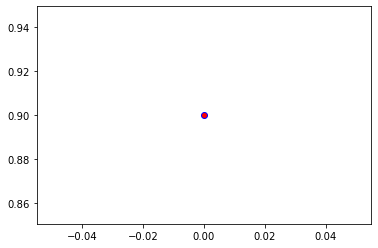

Counter: 362
000000417632 585 = hair spray
000000417779 412 = ashcan
000000417876 355 = llama
000000417911 562 = fountain
000000418062 490 = chain mail
000000418281 37 = ox
000000418696 497 = church
000000418959 49 = African crocodile
000000418961 892 = wall clock
000000419096 565 = freight car
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 0.8999999761581421
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.1], dtype=float32)>)
Model accuracy after perturbation: [0.9]


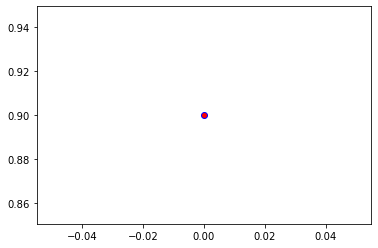

Counter: 363
000000419098 506 = coil
000000419201 958 = hay
000000419312 461 = plate
000000419379 931 = bagel
000000419408 491 = chain saw
000000419601 905 = window shade
000000419653 495 = china cabinet
000000419882 565 = freight car
000000419974 415 = bakery
000000420069 730 = plow
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 0.8999999761581421
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.1], dtype=float32)>)
Model accuracy after perturbation: [0.9]


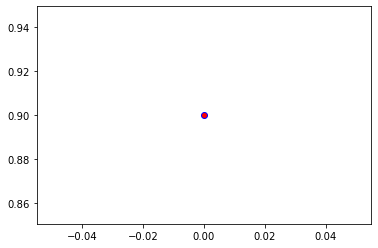

Counter: 364
000000420230 386 = African elephant
000000420281 934 = hotdog
000000420472 62 = rock python
000000420840 929 = ice lolly
000000420916 830 = stretcher
000000421060 404 = liner
000000421455 475 = car mirror
000000421757 536 = dock
000000421834 12 = house finch
000000421923 406 = altar
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 0.8999999761581421
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.1], dtype=float32)>)
Model accuracy after perturbation: [0.9]


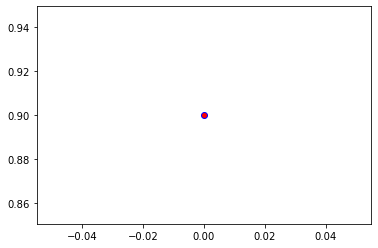

Counter: 365
000000422670 452 = bonnet
000000422706 625 = lifeboat
000000422836 634 = lumbermill
000000422886 965 = burrito
000000422998 909 = wok
000000423104 805 = soccer ball
000000423123 520 = crib
000000423229 820 = steam locomotive
000000423506 457 = bow tie
000000423519 829 = streetcar
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 1.0
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>)
Model accuracy after perturbation: [1.]


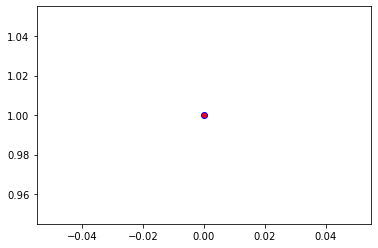

Counter: 366
000000423617 874 = trolleybus
000000423798 920 = traffic light
000000423944 879 = umbrella
000000423971 861 = toilet seat
000000424135 892 = wall clock
000000424162 225 = malinois
000000424349 766 = rotisserie
000000424521 146 = albatross
000000424545 478 = carton
000000424551 248 = ski
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 0.8999999761581421
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.1], dtype=float32)>)
Model accuracy after perturbation: [0.9]


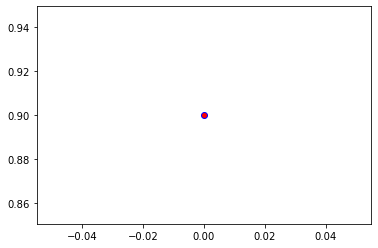

Counter: 367
000000424642 491 = chain saw
000000424721 909 = wok
000000424776 895 = warplane
000000424975 498 = cinema
000000425221 905 = window shade
000000425226 882 = vacuum
000000425227 701 = parachute
000000425361 907 = wine bottle
000000425390 284 = Siamese cat
000000425702 135 = limpkin
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 1.0
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>)
Model accuracy after perturbation: [1.]


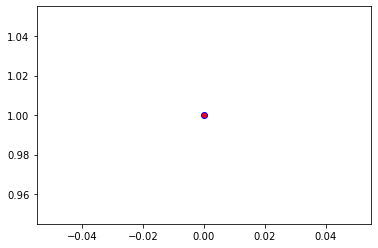

Counter: 368
000000425906 248 = ski
000000425925 668 = mosque
000000426166 880 = unicycle
000000426203 562 = fountain
000000426241 527 = desktop computer
000000426253 651 = microwave
000000426268 820 = steam locomotive
000000426297 340 = zebra
000000426329 999 = toilet tissue
000000426372 569 = garbage truck
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 0.8999999761581421
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.1], dtype=float32)>)
Model accuracy after perturbation: [0.9]


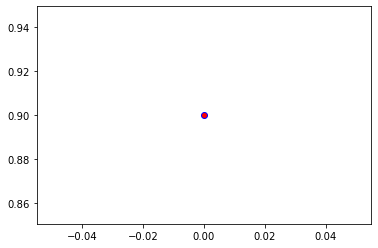

Counter: 369
000000426376 248 = ski
000000426795 118 = Dungeness crab
000000426836 975 = lakeside
000000427034 236 = Doberman
000000427055 498 = cinema
000000427077 981 = ballplayer
000000427160 981 = ballplayer
000000427256 981 = ballplayer
000000427338 663 = monastery
000000427500 324 = cab
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 0.800000011920929
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.2], dtype=float32)>)
Model accuracy after perturbation: [0.8]


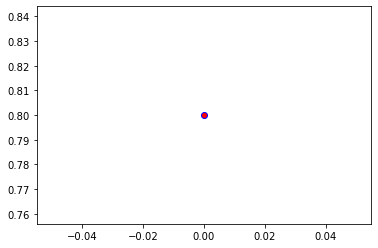

Counter: 370
000000427649 975 = lakeside
000000427655 603 = horse cart
000000427997 358 = pole
000000428111 93 = hornbill
000000428218 621 = lawn mower
000000428280 706 = patio
000000428454 701 = parachute
000000428562 5 = ram
000000428867 850 = teddy
000000429011 561 = forklift
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 0.800000011920929
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.2], dtype=float32)>)
Model accuracy after perturbation: [0.8]


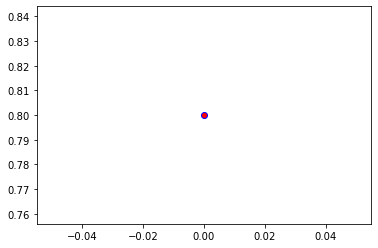

Counter: 371
000000429109 654 = minibus
000000429281 954 = banana
000000429530 883 = vase
000000429598 651 = microwave
000000429623 963 = pizza
000000429690 981 = ballplayer
000000429718 820 = steam locomotive
000000429761 752 = racket
000000430048 539 = doormat
000000430056 933 = cheeseburger
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 1.0
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>)
Model accuracy after perturbation: [1.]


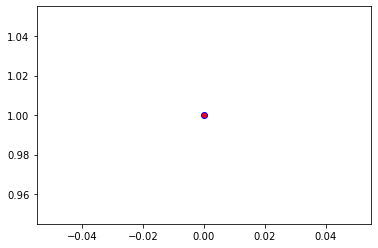

Counter: 372
000000430073 690 = oxcart
000000430286 770 = running shoe
000000430377 248 = ski
000000430871 704 = parking meter
000000430875 920 = traffic light
000000430961 981 = ballplayer
000000430973 963 = pizza
000000431140 896 = washbasin
000000431545 981 = ballplayer
000000431568 963 = pizza
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 0.8999999761581421
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.1], dtype=float32)>)
Model accuracy after perturbation: [0.9]


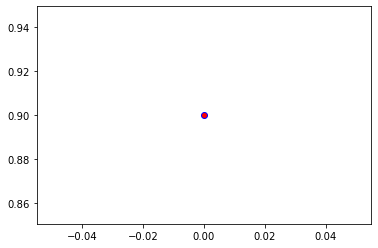

Counter: 373
000000431693 752 = racket
000000431727 334 = porcupine
000000431848 752 = racket
000000431876 433 = bathing cap
000000431896 547 = electric locomotive
000000432085 909 = wok
000000432468 636 = mailbag
000000432553 161 = basset
000000432898 805 = soccer ball
000000433103 830 = stretcher
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 1.0
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>)
Model accuracy after perturbation: [1.]


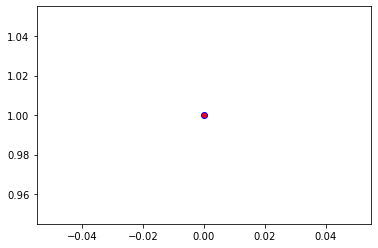

Counter: 374
000000433134 283 = Persian cat
000000433192 750 = quilt
000000433204 660 = mobile home
000000433243 340 = zebra
000000433374 343 = warthog
000000433515 557 = flagpole
000000433774 704 = parking meter
000000433915 851 = television
000000433980 593 = harmonica
000000434204 879 = umbrella
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 1.0
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>)
Model accuracy after perturbation: [1.]


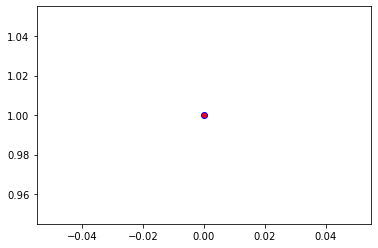

Counter: 375
000000434230 865 = toyshop
000000434247 340 = zebra
000000434297 461 = plate
000000434459 618 = ladle
000000434479 461 = plate
000000434548 981 = ballplayer
000000434996 265 = toy poodle
000000435003 527 = desktop computer
000000435081 932 = pretzel
000000435205 850 = teddy
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 0.800000011920929
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.2], dtype=float32)>)
Model accuracy after perturbation: [0.8]


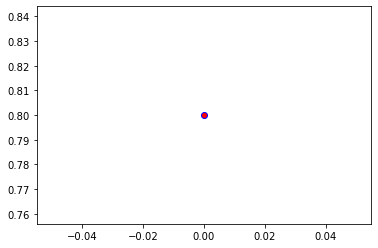

Counter: 376
000000435206 912 = worm fence
000000435208 620 = laptop
000000435299 184 = Irish terrier
000000435880 651 = microwave
000000436315 963 = pizza
000000436551 100 = black swan
000000436617 762 = restaurant
000000436738 874 = trolleybus
000000436883 829 = streetcar
000000437110 498 = palace
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 0.8999999761581421
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.1], dtype=float32)>)
Model accuracy after perturbation: [0.9]


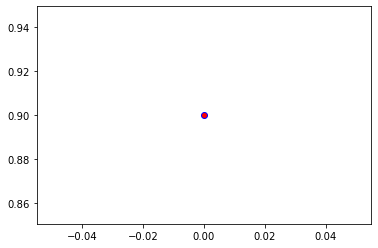

Counter: 377
000000437205 934 = hotdog
000000437239 544 = Dutch oven
000000437331 814 = speedboat
000000437351 859 = toaster
000000437392 861 = toilet seat
000000437514 28 = pot
000000437898 651 = microwave
000000438017 920 = traffic light
000000438226 965 = burrito
000000438269 131 = little blue heron
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 0.8999999761581421
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.1], dtype=float32)>)
Model accuracy after perturbation: [0.9]


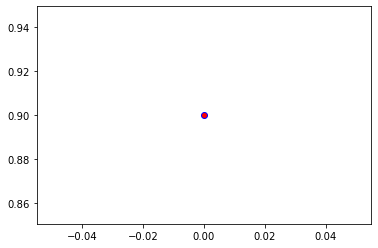

Counter: 378
000000438304 752 = racket
000000438774 762 = restaurant
000000438862 805 = soccer ball
000000438876 752 = racket
000000438907 248 = ski
000000438955 248 = ski
000000439180 354 = Arabian camel
000000439290 954 = banana
000000439426 932 = pretzel
000000439522 248 = ski
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 0.699999988079071
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.3], dtype=float32)>)
Model accuracy after perturbation: [0.7]


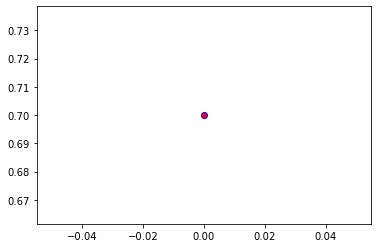

Counter: 379
000000439525 927 = trifle
000000439593 705 = passenger car
000000439623 708 = pedestal
000000439715 603 = horse cart
000000439773 697 = pajama
000000439854 358 = pole
000000439994 981 = ballplayer
000000440171 385 = Indian elephant
000000440184 752 = racket
000000440336 805 = soccer ball
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 0.8999999761581421
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.1], dtype=float32)>)
Model accuracy after perturbation: [0.9]


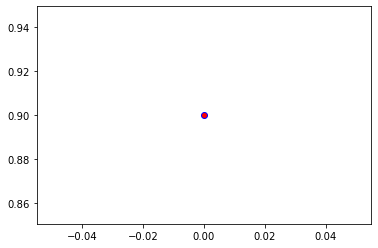

Counter: 380
000000440475 762 = restaurant
000000440507 492 = chest
000000440508 547 = electric locomotive
000000440617 547 = electric locomotive
000000441247 424 = barbershop
000000441286 209 = Chesapeake Bay retriever
000000441442 339 = sorrel
000000441468 637 = mailbox
000000441491 593 = harmonica
000000441543 417 = balloon
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 1.0
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>)
Model accuracy after perturbation: [1.]


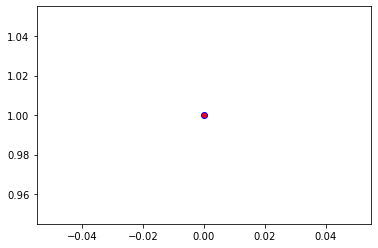

Counter: 381
000000441553 829 = streetcar
000000441586 671 = mountain bike
000000442009 435 = bathtub
000000442161 566 = French horn
000000442306 879 = umbrella
000000442323 851 = television
000000442456 656 = minivan
000000442463 880 = unicycle
000000442480 812 = space shuttle
000000442661 905 = window shade
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 1.0
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>)
Model accuracy after perturbation: [1.]


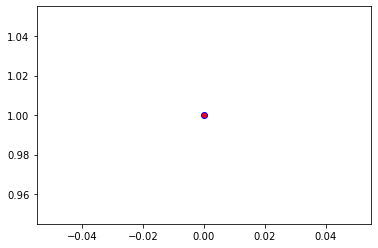

Counter: 382
000000442746 522 = croquet ball
000000442822 536 = dock
000000442836 981 = ballplayer
000000442993 498 = palace
000000443303 588 = hamper
000000443426 683 = oboe
000000443498 407 = ambulance
000000443844 600 = hook
000000443969 791 = shopping cart
000000444142 752 = racket
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 0.8999999761581421
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.1], dtype=float32)>)
Model accuracy after perturbation: [0.9]


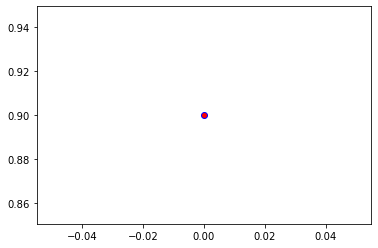

Counter: 383
000000444275 651 = microwave
000000444879 705 = passenger car
000000445248 385 = Indian elephant
000000445365 275 = hyena
000000445439 340 = zebra
000000445602 248 = ski
000000445658 534 = dishwasher
000000445675 288 = leopard
000000445722 476 = carousel
000000445792 845 = syringe
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 0.800000011920929
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.2], dtype=float32)>)
Model accuracy after perturbation: [0.8]


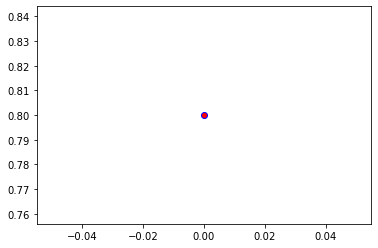

Counter: 384
000000445834 575 = golfcart
000000445846 534 = dishwasher
000000445999 629 = lipstick
000000446005 651 = microwave
000000446117 950 = orange
000000446206 829 = streetcar
000000446207 759 = reflex camera
000000446522 234 = Rottweiler
000000446574 794 = shower curtain
000000446651 518 = crash helmet
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 1.0
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>)
Model accuracy after perturbation: [1.]


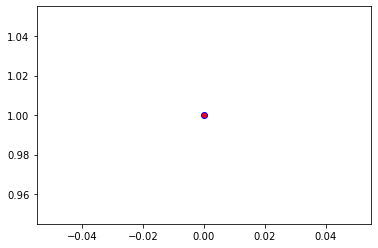

Counter: 385
000000446703 850 = teddy
000000447088 981 = ballplayer
000000447169 651 = microwave
000000447187 981 = ballplayer
000000447200 218 = Welsh springer spaniel
000000447313 340 = zebra
000000447314 140 = alp
000000447342 874 = trolleybus
000000447465 248 = ski
000000447522 461 = plate
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 0.699999988079071
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.3], dtype=float32)>)
Model accuracy after perturbation: [0.7]


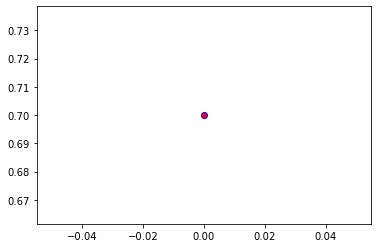

Counter: 386
000000447611 848 = tape player
000000447789 919 = street sign
000000447917 805 = soccer ball
000000448076 819 = stage
000000448256 672 = mountain tent
000000448263 981 = ballplayer
000000448365 880 = unicycle
000000448410 820 = steam locomotive
000000448448 290 = jaguar
000000448810 498 = cinema
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 1.0
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>)
Model accuracy after perturbation: [1.]


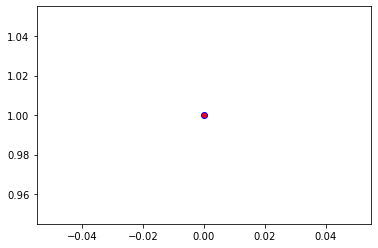

Counter: 387
000000449190 965 = burrito
000000449198 829 = streetcar
000000449312 762 = restaurant
000000449406 340 = zebra
000000449432 654 = minibus
000000449579 752 = racket
000000449603 694 = paddlewheel
000000449661 861 = toilet seat
000000449909 214 = Gordon setter
000000449996 404 = airliner
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 1.0
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>)
Model accuracy after perturbation: [1.]


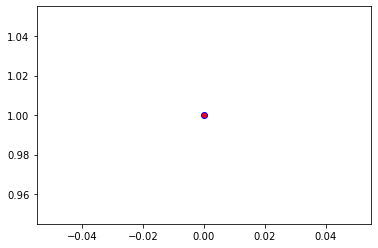

Counter: 388
000000450075 424 = barbershop
000000450100 415 = bakery
000000450202 118 = Dungeness crab
000000450303 526 = desk
000000450399 582 = grocery store
000000450439 701 = parachute
000000450488 598 = home theater
000000450559 752 = racket
000000450686 487 = cellular telephone
000000450758 351 = hartebeest
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 1.0
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>)
Model accuracy after perturbation: [1.]


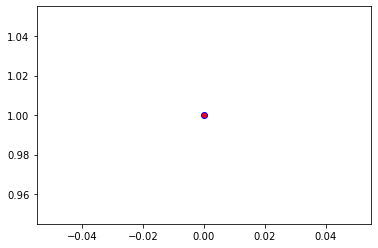

Counter: 389
000000451043 248 = ski
000000451084 248 = ski
000000451090 914 = yawl
000000451144 248 = ski
000000451150 932 = pretzel
000000451155 905 = window shade
000000451308 553 = file
000000451435 722 = ping-pong ball
000000451571 66 = corn
000000451693 963 = pizza
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 0.6000000238418579
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.4], dtype=float32)>)
Model accuracy after perturbation: [0.6]


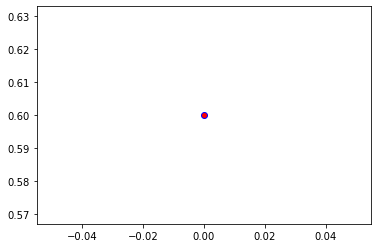

Counter: 390
000000451714 248 = ski
000000451879 429 = baseball
000000452084 813 = spatula
000000452122 404 = airliner
000000452321 874 = trolleybus
000000452515 752 = racket
000000452784 937 = broccoli
000000452793 534 = dishwasher
000000452891 266 = miniature poodle
000000453001 401 = accordion
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 0.8999999761581421
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.1], dtype=float32)>)
Model accuracy after perturbation: [0.9]


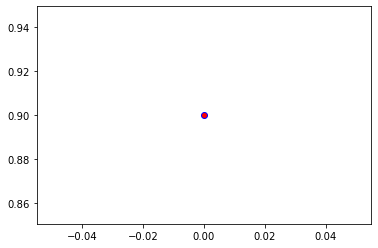

Counter: 391
000000453040 28 = pot
000000453166 652 = military uniform
000000453302 651 = microwave
000000453341 495 = china cabinet
000000453584 694 = paddlewheel
000000453634 896 = washbasin
000000453708 954 = banana
000000453722 564 = four-poster
000000453841 920 = traffic light
000000453860 636 = mailbag
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 0.8999999761581421
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.1], dtype=float32)>)
Model accuracy after perturbation: [0.9]


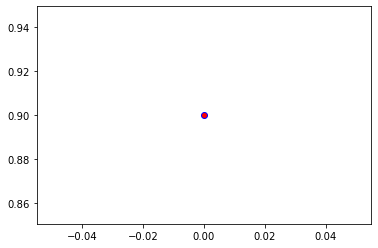

Counter: 392
000000453981 295 = American black bear
000000454067 851 = television
000000454404 899 = water jug
000000454661 324 = cab
000000454750 340 = zebra
000000454798 339 = sorrel
000000454978 671 = mountain bike
000000455085 705 = passenger car
000000455157 634 = lumbermill
000000455219 37 = ox
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 0.800000011920929
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.2], dtype=float32)>)
Model accuracy after perturbation: [0.8]


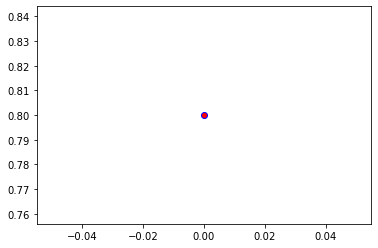

Counter: 393
000000455267 909 = wok
000000455301 529 = diaper
000000455352 442 = bell cote
000000455448 641 = maraca
000000455555 843 = swing
000000455597 424 = barbershop
000000455624 670 = motor scooter
000000455716 670 = motor scooter
000000455872 536 = dock
000000455937 762 = restaurant
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 1.0
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>)
Model accuracy after perturbation: [1.]


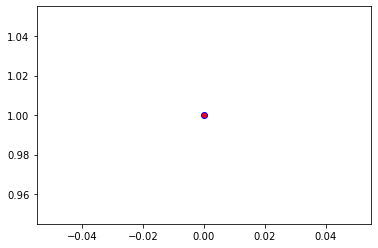

Counter: 394
000000455981 861 = toilet seat
000000456015 354 = Arabian camel
000000456143 933 = cheeseburger
000000456292 896 = washbasin
000000456303 802 = snowmobile
000000456394 665 = moped
000000456496 703 = park bench
000000456559 837 = sunglasses
000000456662 416 = balance beam
000000456865 404 = airliner
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 1.0
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>)
Model accuracy after perturbation: [1.]


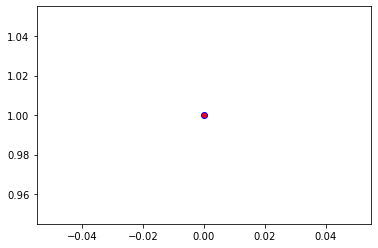

Counter: 395
000000457078 424 = barbershop
000000457262 954 = banana
000000457559 805 = soccer ball
000000457848 665 = moped
000000457884 981 = ballplayer
000000458045 981 = ballplayer
000000458054 391 = coho
000000458109 565 = freight car
000000458223 460 = breakwater
000000458255 750 = quilt
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 1.0
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>)
Model accuracy after perturbation: [1.]


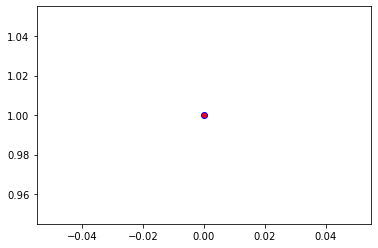

Counter: 396
000000458325 569 = garbage truck
000000458410 651 = microwave
000000458663 534 = dishwasher
000000458702 704 = parking meter
000000458755 5 = ram
000000458768 896 = washbasin
000000458790 851 = television
000000458992 963 = pizza
000000459153 703 = park bench
000000459195 491 = chain saw
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 0.8999999761581421
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.1], dtype=float32)>)
Model accuracy after perturbation: [0.9]


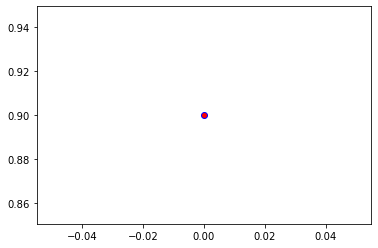

Counter: 397
000000459272 611 = jigsaw puzzle
000000459396 37 = ox
000000459437 354 = Arabian camel
000000459467 318 = wing
000000459500 409 = analog clock
000000459634 977 = sandbar
000000459662 641 = maraca
000000459757 9 = ostrich
000000459809 701 = parachute
000000459887 954 = banana
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 0.800000011920929
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.2], dtype=float32)>)
Model accuracy after perturbation: [0.8]


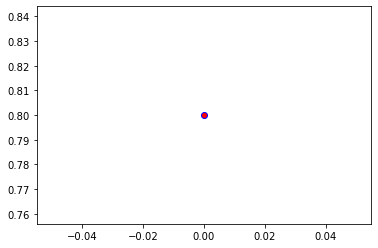

Counter: 398
000000459954 760 = refrigerator
000000460147 920 = traffic light
000000460160 99 = goose
000000460229 919 = street sign
000000460333 831 = studio couch
000000460347 675 = moving van
000000460379 9 = ostrich
000000460494 937 = broccoli
000000460682 693 = paddle
000000460683 639 = suit
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 0.8999999761581421
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.1], dtype=float32)>)
Model accuracy after perturbation: [0.9]


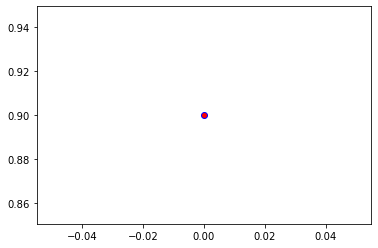

Counter: 399
000000460841 896 = washbasin
000000460927 294 = brown bear
000000460929 934 = hotdog
000000460967 874 = trolleybus
000000461009 852 = tennis ball
000000461036 379 = howler monkey
000000461275 919 = street sign
000000461405 5 = ram
000000461573 703 = park bench
000000461751 428 = barrow
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 0.8999999761581421
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.1], dtype=float32)>)
Model accuracy after perturbation: [0.9]


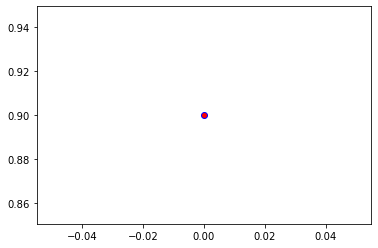

Counter: 400
000000462031 981 = ballplayer
000000462371 822 = steel drum
000000462576 935 = mashed potato
000000462614 896 = washbasin
000000462629 760 = refrigerator
000000462643 681 = notebook
000000462728 814 = speedboat
000000462756 856 = thresher
000000462904 37 = ox
000000463037 895 = warplane
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 0.8999999761581421
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.1], dtype=float32)>)
Model accuracy after perturbation: [0.9]


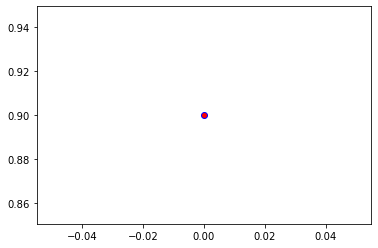

Counter: 401
000000463174 752 = racket
000000463199 515 = cowboy hat
000000463283 969 = eggnog
000000463522 603 = horse cart
000000463527 868 = tray
000000463542 248 = ski
000000463618 791 = shopping cart
000000463647 637 = mailbox
000000463690 675 = moving van
000000463730 569 = garbage truck
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 0.8999999761581421
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.1], dtype=float32)>)
Model accuracy after perturbation: [0.9]


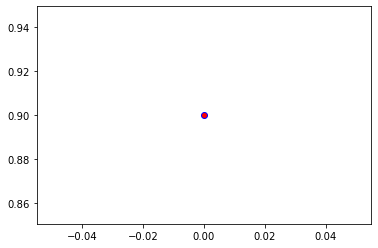

Counter: 402
000000463802 529 = diaper
000000463842 831 = studio couch
000000463849 536 = dock
000000463918 642 = marimba
000000464089 981 = ballplayer
000000464144 248 = ski
000000464251 12 = house finch
000000464358 532 = dining table
000000464476 799 = sliding door
000000464522 164 = bluetick
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 0.8999999761581421
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.1], dtype=float32)>)
Model accuracy after perturbation: [0.9]


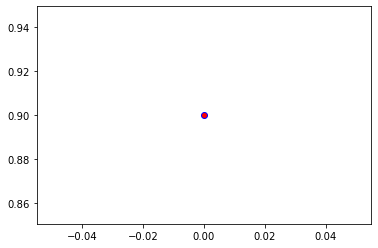

Counter: 403
000000464689 624 = library
000000464786 934 = hotdog
000000464824 544 = Dutch oven
000000464872 340 = zebra
000000465129 456 = bow
000000465179 422 = barbell
000000465180 385 = Indian elephant
000000465430 962 = meat loaf
000000465549 589 = hand blower
000000465585 937 = broccoli
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 1.0
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>)
Model accuracy after perturbation: [1.]


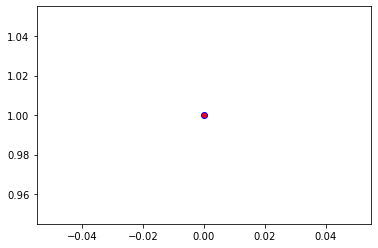

Counter: 404
000000465675 471 = cannon
000000465718 527 = desktop computer
000000465806 953 = pineapple
000000465822 589 = hand blower
000000465836 248 = ski
000000466085 435 = bathtub
000000466125 879 = umbrella
000000466156 285 = Egyptian cat
000000466256 461 = plate
000000466339 799 = sliding door
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 0.800000011920929
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.2], dtype=float32)>)
Model accuracy after perturbation: [0.8]


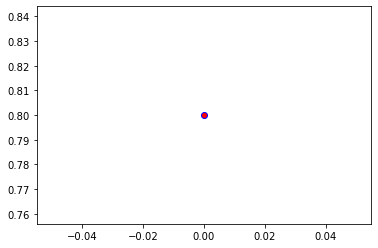

Counter: 405
000000466416 498 = palace
000000466567 607 = jack-o'-lantern
000000466602 792 = shovel
000000466835 954 = banana
000000466986 651 = microwave
000000467176 851 = television
000000467315 883 = vase
000000467511 670 = motor scooter
000000467776 355 = llama
000000467848 867 = trailer truck
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 0.8999999761581421
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.1], dtype=float32)>)
Model accuracy after perturbation: [0.9]


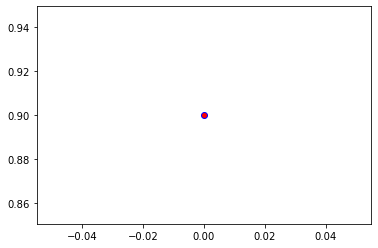

Counter: 406
000000468124 408 = amphibian
000000468233 710 = pencil sharpener
000000468245 905 = window shade
000000468332 575 = golfcart
000000468501 515 = cowboy hat
000000468505 532 = dining table
000000468577 209 = Chesapeake Bay retriever
000000468632 890 = volleyball
000000468925 461 = plate
000000468954 608 = jean
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 0.8999999761581421
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.1], dtype=float32)>)
Model accuracy after perturbation: [0.9]


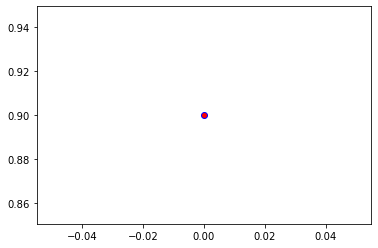

Counter: 407
000000468965 663 = monastery
000000469067 845 = syringe
000000469174 557 = flagpole
000000469192 656 = minivan
000000469246 705 = passenger car
000000469652 287 = lynx
000000469828 248 = ski
000000470121 461 = plate
000000470173 863 = totem pole
000000470773 415 = bakery
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 0.800000011920929
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.2], dtype=float32)>)
Model accuracy after perturbation: [0.8]


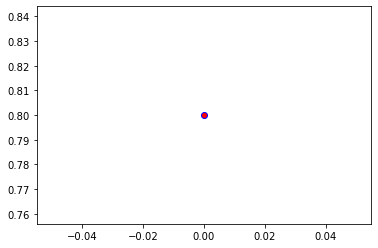

Counter: 408
000000470779 248 = ski
000000470924 982 = groom
000000470952 248 = ski
000000471023 475 = car mirror
000000471087 869 = trench coat
000000471450 294 = brown bear
000000471567 663 = monastery
000000471756 693 = paddle
000000471789 557 = flagpole
000000471869 850 = teddy
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 0.800000011920929
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.2], dtype=float32)>)
Model accuracy after perturbation: [0.8]


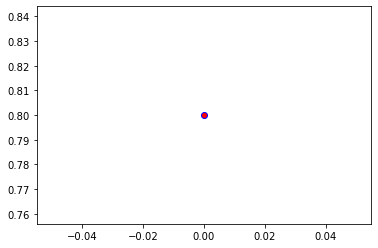

Counter: 409
000000471893 642 = marimba
000000471991 497 = church
000000472030 703 = park bench
000000472046 762 = restaurant
000000472298 472 = canoe
000000472375 235 = German shepherd
000000472623 671 = mountain bike
000000472678 527 = desktop computer
000000473015 58 = water snake
000000473118 752 = racket
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 1.0
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>)
Model accuracy after perturbation: [1.]


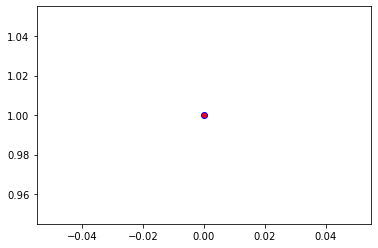

Counter: 410
000000473121 248 = ski
000000473219 982 = groom
000000473237 965 = burrito
000000473406 443 = bib
000000473821 598 = home theater
000000473869 909 = wok
000000473974 340 = zebra
000000474021 420 = banjo
000000474028 768 = rugby ball
000000474039 850 = teddy
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 0.8999999761581421
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.1], dtype=float32)>)
Model accuracy after perturbation: [0.9]


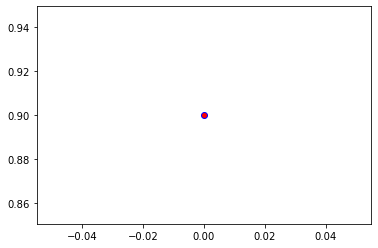

Counter: 411
000000474078 981 = ballplayer
000000474095 896 = washbasin
000000474164 212 = English setter
000000474167 934 = hotdog
000000474170 386 = African elephant
000000474293 860 = tobacco shop
000000474344 456 = bow
000000474452 919 = street sign
000000474786 896 = washbasin
000000474854 929 = ice lolly
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 1.0
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>)
Model accuracy after perturbation: [1.]


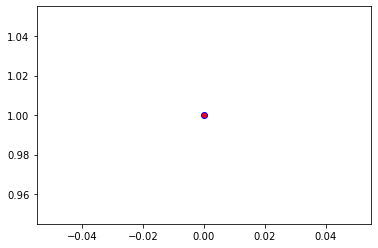

Counter: 412
000000474881 349 = bighorn
000000475064 932 = pretzel
000000475150 352 = impala
000000475191 752 = racket
000000475223 133 = bittern
000000475365 867 = trailer truck
000000475387 547 = electric locomotive
000000475484 704 = parking meter
000000475572 868 = tray
000000475678 461 = breastplate
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 1.0
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>)
Model accuracy after perturbation: [1.]


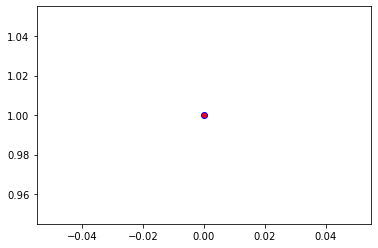

Counter: 413
000000475732 282 = tiger cat
000000475779 386 = African elephant
000000475904 879 = umbrella
000000476119 491 = chain saw
000000476215 603 = horse cart
000000476258 248 = ski
000000476415 906 = Windsor tie
000000476491 713 = pier
000000476514 982 = groom
000000476704 757 = recreational vehicle
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 0.800000011920929
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.2], dtype=float32)>)
Model accuracy after perturbation: [0.8]


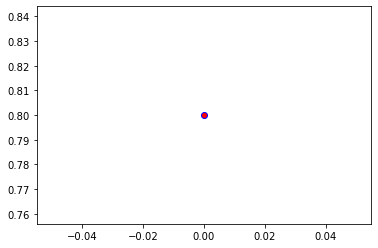

Counter: 414
000000476770 981 = ballplayer
000000476787 963 = pizza
000000476810 761 = remote control
000000477118 919 = street sign
000000477227 554 = fireboat
000000477288 456 = bow
000000477441 318 = wing
000000477623 547 = electric locomotive
000000477689 982 = groom
000000477805 639 = suit
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 0.800000011920929
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.2], dtype=float32)>)
Model accuracy after perturbation: [0.8]


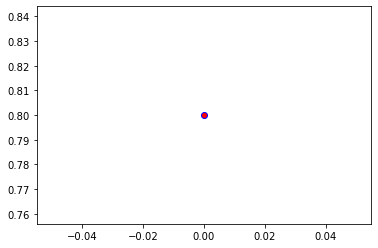

Counter: 415
000000477955 701 = parachute
000000478136 415 = bakery
000000478286 779 = school bus
000000478393 162 = beagle
000000478420 775 = sarong
000000478474 867 = trailer truck
000000478721 843 = swing
000000478862 895 = warplane
000000479030 547 = electric locomotive
000000479099 73 = barn
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 0.8999999761581421
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.1], dtype=float32)>)
Model accuracy after perturbation: [0.9]


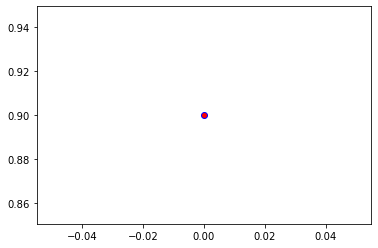

Counter: 416
000000479126 620 = laptop
000000479155 248 = Eskimo dog
000000479248 851 = television
000000479448 954 = banana
000000479596 950 = orange
000000479732 933 = cheeseburger
000000479912 404 = airliner
000000479953 752 = racket
000000480021 665 = moped
000000480122 532 = dining table
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 1.0
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>)
Model accuracy after perturbation: [1.]


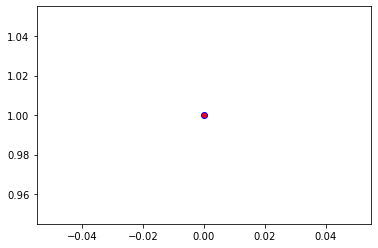

Counter: 417
000000480212 761 = remote control
000000480275 66 = corn
000000480842 383 = Madagascar cat
000000480936 655 = miniskirt
000000480944 920 = traffic light
000000480985 524 = cuirass
000000481159 703 = park bench
000000481386 860 = tobacco shop
000000481390 430 = basketball
000000481404 497 = church
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 0.8999999761581421
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.1], dtype=float32)>)
Model accuracy after perturbation: [0.9]


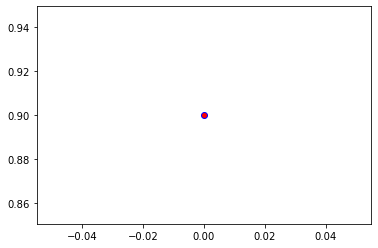

Counter: 418
000000481413 978 = seashore
000000481480 557 = flagpole
000000481567 665 = moped
000000481573 807 = solar dish
000000481582 385 = Indian elephant
000000482100 861 = toilet seat
000000482275 982 = groom
000000482319 680 = nipple
000000482436 424 = barbershop
000000482477 21 = kite
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 1.0
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>)
Model accuracy after perturbation: [1.]


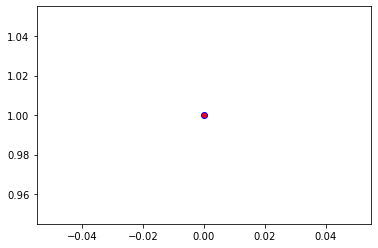

Counter: 419
000000482487 778 = scale
000000482585 705 = passenger car
000000482719 954 = banana
000000482735 148 = killer whale
000000482800 522 = croquet ball
000000482917 264 = Cardigan
000000482970 620 = laptop
000000482978 705 = passenger car
000000483050 750 = quilt
000000483531 831 = studio couch
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 1.0
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>)
Model accuracy after perturbation: [1.]


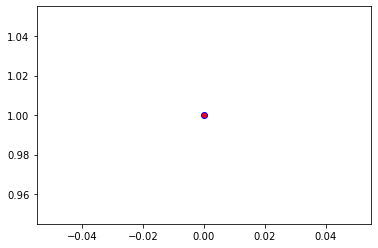

Counter: 420
000000483667 515 = cowboy hat
000000483999 762 = restaurant
000000484029 919 = street sign
000000484296 340 = zebra
000000484351 624 = library
000000484404 705 = passenger car
000000484415 861 = toilet seat
000000484760 442 = bell cote
000000484893 105 = koala
000000484978 532 = dining table
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 1.0
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>)
Model accuracy after perturbation: [1.]


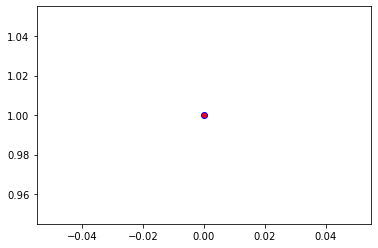

Counter: 421
000000485027 752 = racket
000000485071 814 = speedboat
000000485130 478 = carton
000000485237 404 = airliner
000000485424 651 = microwave
000000485480 981 = ballplayer
000000485802 79 = centipede
000000485844 424 = barbershop
000000485895 649 = megalith
000000485972 813 = spatula
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 1.0
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>)
Model accuracy after perturbation: [1.]


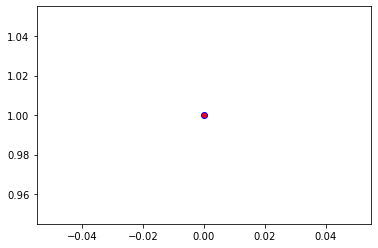

Counter: 422
000000486040 4 = hammer
000000486046 340 = zebra
000000486104 981 = ballplayer
000000486112 385 = Indian elephant
000000486438 932 = pretzel
000000486479 161 = basset
000000486573 870 = tricycle
000000487583 412 = ashcan
000000488075 532 = dining table
000000488166 696 = paintbrush
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 0.8999999761581421
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.1], dtype=float32)>)
Model accuracy after perturbation: [0.9]


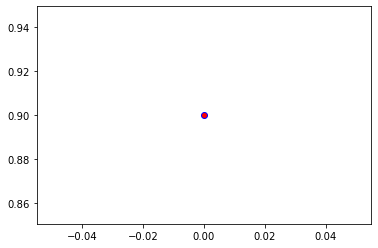

Counter: 423
000000488251 339 = sorrel
000000488270 977 = sandbar
000000488385 665 = moped
000000488592 582 = grocery store
000000488664 820 = steam locomotive
000000488673 505 = coffeepot
000000488710 610 = jersey
000000488736 409 = analog clock
000000489014 914 = yawl
000000489046 326 = lycaenid
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 1.0
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>)
Model accuracy after perturbation: [1.]


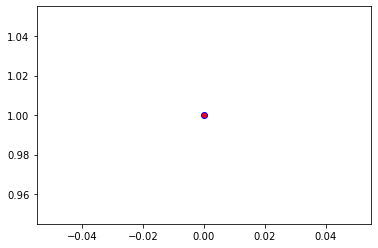

Counter: 424
000000489091 648 = medicine chest
000000489305 942 = butternut squash
000000489339 456 = bow
000000489611 845 = syringe
000000489764 424 = barbershop
000000489842 903 = wig
000000489924 774 = sandal
000000490125 144 = pelican
000000490171 175 = otter
000000490413 489 = chainlink fence
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 0.8999999761581421
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.1], dtype=float32)>)
Model accuracy after perturbation: [0.9]


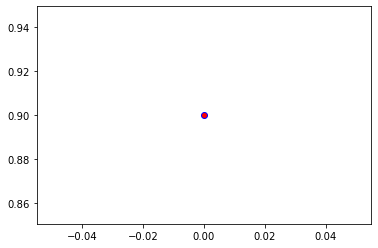

Counter: 425
000000490470 484 = catamaran
000000490515 248 = ski
000000490936 601 = hoopskirt
000000491008 752 = racket
000000491071 598 = home theater
000000491090 665 = moped
000000491130 248 = ski
000000491213 665 = moped
000000491216 526 = desk
000000491366 851 = television
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 0.800000011920929
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.2], dtype=float32)>)
Model accuracy after perturbation: [0.8]


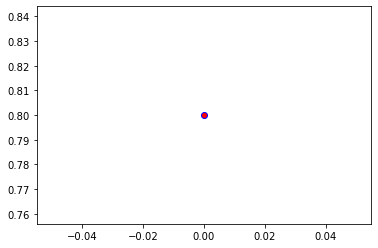

Counter: 426
000000491464 981 = ballplayer
000000491470 888 = viaduct
000000491497 564 = four-poster
000000491613 340 = zebra
000000491683 958 = hay
000000491725 536 = dock
000000491757 284 = Siamese cat
000000491867 887 = vestment
000000492077 665 = moped
000000492110 620 = laptop
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 1.0
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>)
Model accuracy after perturbation: [1.]


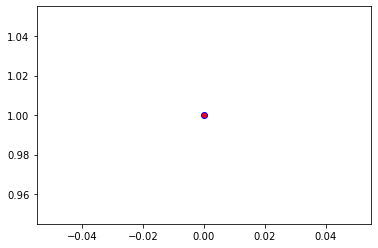

Counter: 427
000000492282 603 = horse cart
000000492284 37 = ox
000000492362 582 = grocery store
000000492758 706 = patio
000000492878 896 = washbasin
000000492905 526 = desk
000000492937 872 = tripod
000000492968 248 = ski
000000492992 346 = water buffalo
000000493019 340 = zebra
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 0.800000011920929
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.2], dtype=float32)>)
Model accuracy after perturbation: [0.8]


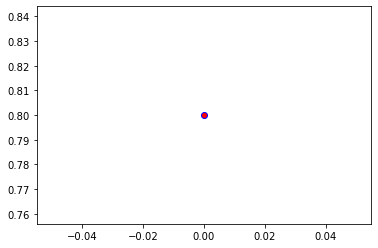

Counter: 428
000000493284 386 = African elephant
000000493286 511 = convertible
000000493334 520 = crib
000000493442 248 = ski
000000493566 565 = freight car
000000493613 770 = running shoe
000000493772 879 = umbrella
000000493799 461 = plate
000000493864 879 = umbrella
000000493905 805 = soccer ball
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 0.800000011920929
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.2], dtype=float32)>)
Model accuracy after perturbation: [0.8]


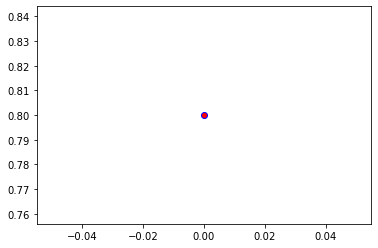

Counter: 429
000000494188 23 = vulture
000000494427 681 = notebook
000000494634 664 = monitor
000000494759 701 = parachute
000000494863 547 = electric locomotive
000000494869 788 = shoe shop
000000494913 598 = home theater
000000495054 404 = airliner
000000495146 557 = flagpole
000000495448 415 = bakery
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 1.0
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>)
Model accuracy after perturbation: [1.]


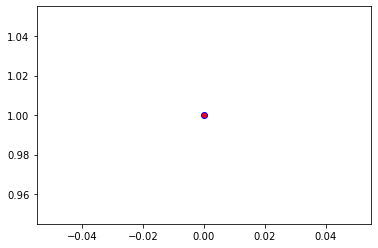

Counter: 430
000000495732 608 = jean
000000496409 314 = cockroach
000000496571 532 = dining table
000000496597 976 = promontory
000000496722 637 = mailbox
000000496854 879 = umbrella
000000496954 461 = plate
000000497344 681 = notebook
000000497568 404 = airliner
000000497599 739 = potter's wheel
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 0.8999999761581421
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.1], dtype=float32)>)
Model accuracy after perturbation: [0.9]


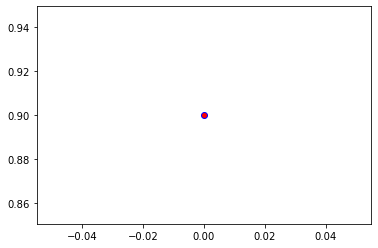

Counter: 431
000000497628 564 = four-poster
000000497867 654 = minibus
000000498032 585 = hair spray
000000498286 182 = Border terrier
000000498463 760 = refrigerator
000000498709 670 = motor scooter
000000498747 523 = crutch
000000498807 693 = paddle
000000498857 134 = crane
000000498919 950 = orange
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 1.0
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>)
Model accuracy after perturbation: [1.]


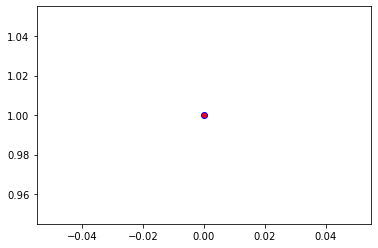

Counter: 432
000000499031 655 = miniskirt
000000499109 329 = cucumber
000000499181 920 = traffic light
000000499266 605 = iPod
000000499313 963 = pizza
000000499622 518 = crash helmet
000000499768 637 = mailbox
000000499775 874 = trolleybus
000000500049 404 = airliner
000000500211 716 = picket fence
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 0.8999999761581421
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.1], dtype=float32)>)
Model accuracy after perturbation: [0.9]


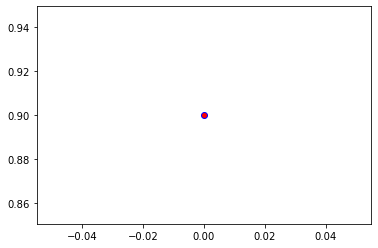

Counter: 433
000000500257 670 = motor scooter
000000500270 532 = dining table
000000500423 705 = passenger car
000000500464 896 = washbasin
000000500477 961 = dough
000000500478 981 = ballplayer
000000500565 434 = bath towel
000000500613 555 = fire engine
000000500663 975 = lakeside
000000500716 487 = cellular telephone
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 1.0
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>)
Model accuracy after perturbation: [1.]


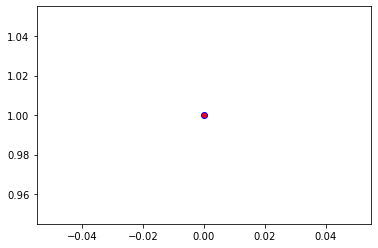

Counter: 434
000000500826 919 = street sign
000000501005 981 = ballplayer
000000501023 919 = street sign
000000501243 340 = zebra
000000501368 589 = hand blower
000000501523 896 = washbasin
000000502136 743 = prison
000000502168 833 = submarine
000000502229 611 = jigsaw puzzle
000000502336 424 = barbershop
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 1.0
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>)
Model accuracy after perturbation: [1.]


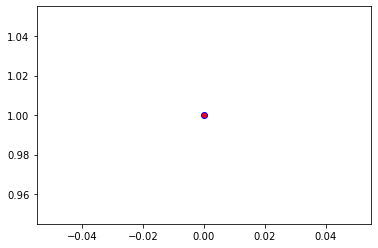

Counter: 435
000000502347 405 = airship
000000502599 657 = missile
000000502732 877 = turnstile
000000502737 960 = chocolate sauce
000000502910 637 = mailbox
000000503755 752 = racket
000000503823 864 = wreck
000000503841 920 = traffic light
000000503855 672 = mountain tent
000000504000 807 = solar dish
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 0.8999999761581421
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.1], dtype=float32)>)
Model accuracy after perturbation: [0.9]


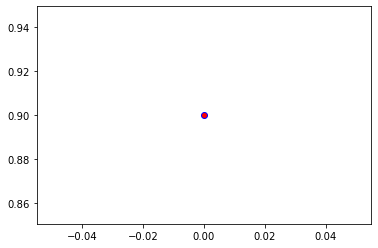

Counter: 436
000000504074 401 = accordion
000000504389 792 = shovel
000000504415 890 = volleyball
000000504439 340 = zebra
000000504580 83 = prairie chicken
000000504589 890 = volleyball
000000504635 340 = zebra
000000504711 960 = chocolate sauce
000000505169 794 = shower curtain
000000505451 801 = snorkel
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 1.0
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>)
Model accuracy after perturbation: [1.]


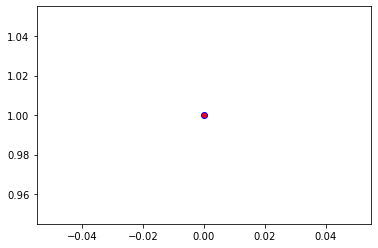

Counter: 437
000000505565 127 = white stork
000000505573 245 = French bulldog
000000505638 820 = steam locomotive
000000505789 663 = monastery
000000505942 704 = parking meter
000000506004 540 = drilling platform
000000506178 851 = television
000000506279 441 = beer glass
000000506310 707 = pay-phone
000000506454 703 = park bench
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 1.0
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>)
Model accuracy after perturbation: [1.]


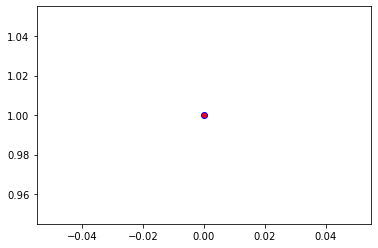

Counter: 438
000000506656 603 = horse cart
000000506707 981 = ballplayer
000000506933 487 = cellular telephone
000000507015 981 = ballplayer
000000507037 880 = unicycle
000000507042 293 = cheetah
000000507081 799 = sliding door
000000507223 981 = ballplayer
000000507235 461 = plate
000000507473 487 = cellular telephone
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 0.8999999761581421
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.1], dtype=float32)>)
Model accuracy after perturbation: [0.9]


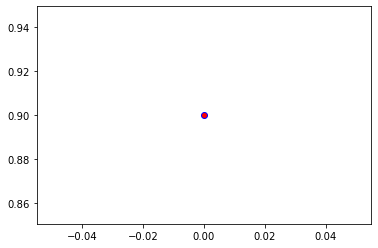

Counter: 439
000000507575 526 = desk
000000507667 407 = ambulance
000000507797 829 = streetcar
000000507893 648 = medicine chest
000000507975 603 = horse cart
000000508101 693 = paddle
000000508312 651 = microwave
000000508370 444 = bicycle-built-for-two
000000508482 877 = turnstile
000000508586 340 = zebra
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 1.0
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>)
Model accuracy after perturbation: [1.]


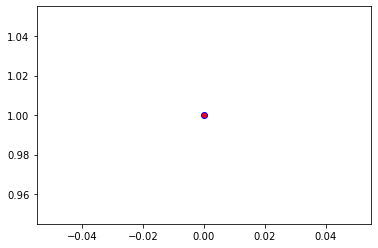

Counter: 440
000000508602 132 = American egret
000000508639 603 = horse cart
000000508730 793 = shower cap
000000508917 705 = passenger car
000000509008 779 = school bus
000000509014 248 = ski
000000509131 986 = yellow lady's slipper
000000509258 498 = cinema
000000509260 453 = bookcase
000000509403 173 = Ibizan hound
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 0.8999999761581421
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.1], dtype=float32)>)
Model accuracy after perturbation: [0.9]


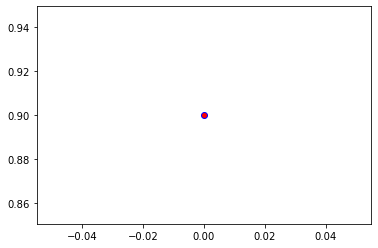

Counter: 441
000000509451 541 = drum
000000509656 340 = zebra
000000509699 424 = barbershop
000000509719 82 = ruffed grouse
000000509735 340 = zebra
000000509824 831 = studio couch
000000510095 984 = rapeseed
000000510329 471 = cannon
000000511076 634 = lumbermill
000000511321 404 = liner
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 0.8999999761581421
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.1], dtype=float32)>)
Model accuracy after perturbation: [0.9]


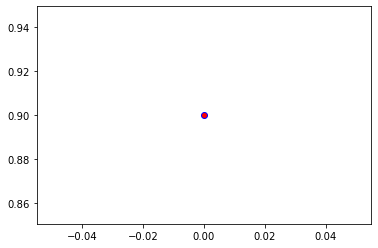

Counter: 442
000000511384 417 = balloon
000000511398 161 = basset
000000511453 934 = hotdog
000000511599 977 = sandbar
000000511647 99 = goose
000000511760 701 = parachute
000000511999 705 = passenger car
000000512194 883 = vase
000000512248 409 = analog clock
000000512330 760 = refrigerator
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 1.0
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>)
Model accuracy after perturbation: [1.]


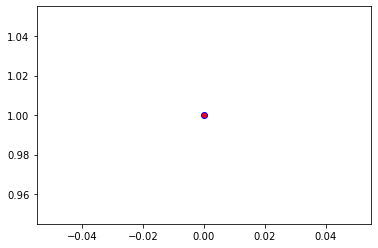

Counter: 443
000000512403 749 = quill
000000512476 786 = sewing machine
000000512564 829 = streetcar
000000512648 37 = ox
000000512657 608 = jean
000000512776 981 = ballplayer
000000512836 879 = umbrella
000000512929 910 = wooden spoon
000000512985 978 = seashore
000000513041 544 = Dutch oven
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 0.8999999761581421
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.1], dtype=float32)>)
Model accuracy after perturbation: [0.9]


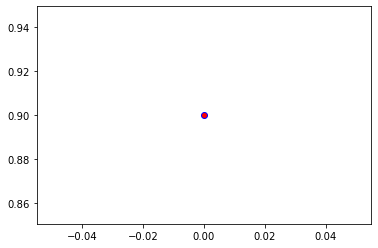

Counter: 444
000000513181 536 = dock
000000513283 461 = plate
000000513484 294 = brown bear
000000513524 178 = Weimaraner
000000513567 971 = bubble
000000513580 318 = wing
000000513688 526 = desk
000000514376 829 = streetcar
000000514508 654 = minibus
000000514540 919 = street sign
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 0.800000011920929
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.2], dtype=float32)>)
Model accuracy after perturbation: [0.8]


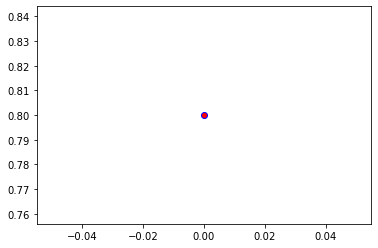

Counter: 445
000000514586 456 = bow
000000514797 538 = dome
000000514914 896 = washbasin
000000514979 385 = Indian elephant
000000515025 231 = collie
000000515077 598 = home theater
000000515266 864 = tow truck
000000515350 241 = EntleBucher
000000515445 978 = seashore
000000515577 140 = alp
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 0.8999999761581421
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.1], dtype=float32)>)
Model accuracy after perturbation: [0.9]


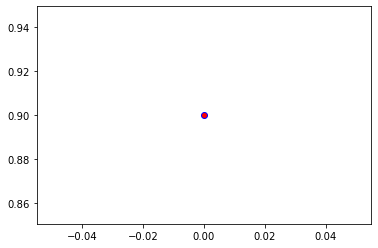

Counter: 446
000000515579 805 = soccer ball
000000515828 752 = racket
000000515982 981 = ballplayer
000000516038 981 = ballplayer
000000516143 654 = minibus
000000516173 978 = seashore
000000516316 340 = zebra
000000516318 693 = paddle
000000516601 140 = alp
000000516677 140 = alp
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 0.800000011920929
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.2], dtype=float32)>)
Model accuracy after perturbation: [0.8]


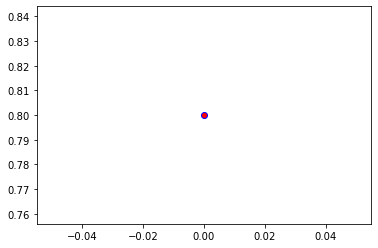

Counter: 447
000000516708 919 = street sign
000000516804 920 = traffic light
000000516871 748 = purse
000000516916 526 = desk
000000517056 762 = restaurant
000000517069 420 = banjo
000000517523 404 = airliner
000000517687 487 = cellular telephone
000000517832 179 = Staffordshire bullterrier
000000518213 347 = bison
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 1.0
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>)
Model accuracy after perturbation: [1.]


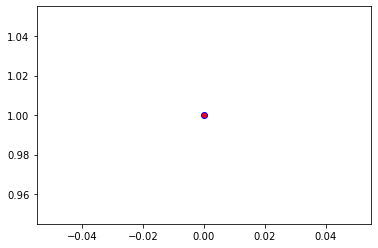

Counter: 448
000000518326 791 = shopping cart
000000518770 523 = crutch
000000519039 569 = garbage truck
000000519208 385 = Indian elephant
000000519338 565 = freight car
000000519491 442 = bell cote
000000519522 498 = palace
000000519569 896 = washbasin
000000519611 296 = ice bear
000000519688 361 = skunk
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 0.8999999761581421
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.1], dtype=float32)>)
Model accuracy after perturbation: [0.9]


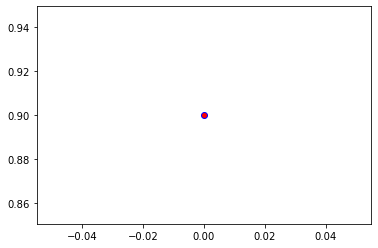

Counter: 449
000000519764 281 = tabby
000000520009 498 = palace
000000520077 481 = cassette
000000520264 534 = dishwasher
000000520301 227 = kelpie
000000520324 575 = golfcart
000000520531 453 = bookcase
000000520659 476 = carousel
000000520707 297 = slot
000000520832 829 = streetcar
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 0.800000011920929
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.2], dtype=float32)>)
Model accuracy after perturbation: [0.8]


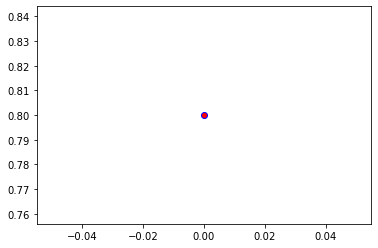

Counter: 450
000000520871 963 = pizza
000000520910 697 = pajama
000000521052 660 = mobile home
000000521141 919 = street sign
000000521231 296 = ice bear
000000521259 880 = unicycle
000000521282 883 = vase
000000521405 816 = spindle
000000521509 523 = crutch
000000521540 461 = plate
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 0.8999999761581421
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.1], dtype=float32)>)
Model accuracy after perturbation: [0.9]


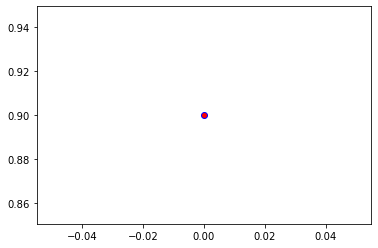

Counter: 451
000000521601 896 = washbasin
000000521717 752 = racket
000000521719 723 = pinwheel
000000521819 522 = croquet ball
000000521956 752 = racket
000000522007 651 = microwave
000000522156 461 = plate
000000522393 914 = yawl
000000522638 850 = teddy
000000522713 703 = park bench
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 0.8999999761581421
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.1], dtype=float32)>)
Model accuracy after perturbation: [0.9]


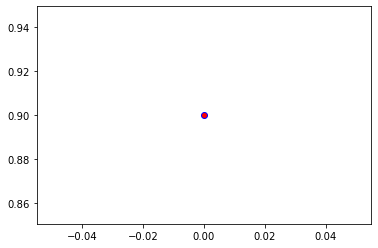

Counter: 452
000000522751 920 = traffic light
000000522889 752 = racket
000000522940 919 = street sign
000000523033 977 = sandbar
000000523100 909 = wok
000000523175 809 = soup bowl
000000523194 879 = umbrella
000000523229 861 = toilet seat
000000523241 920 = traffic light
000000523782 656 = minivan
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 1.0
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>)
Model accuracy after perturbation: [1.]


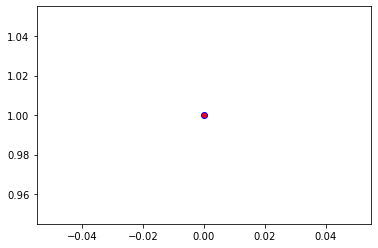

Counter: 453
000000523807 934 = hotdog
000000523811 912 = worm fence
000000523957 460 = breakwater
000000524108 670 = motor scooter
000000524280 285 = Egyptian cat
000000524456 882 = vacuum
000000524742 709 = pencil box
000000524850 404 = airliner
000000525083 424 = barbershop
000000525155 5 = ram
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 0.8999999761581421
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.1], dtype=float32)>)
Model accuracy after perturbation: [0.9]


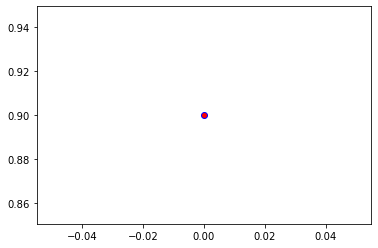

Counter: 454
000000525247 508 = computer keyboard
000000525286 635 = magnetic compass
000000525322 318 = wing
000000525600 355 = llama
000000526103 385 = Indian elephant
000000526197 415 = bakery
000000526256 663 = monastery
000000526392 656 = minivan
000000526706 347 = bison
000000526728 412 = ashcan
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 0.8999999761581421
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.1], dtype=float32)>)
Model accuracy after perturbation: [0.9]


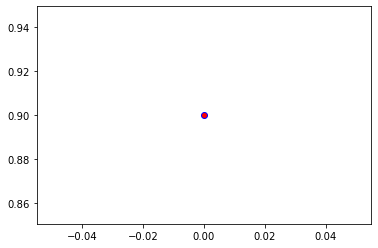

Counter: 455
000000526751 484 = catamaran
000000527029 415 = bakery
000000527215 890 = volleyball
000000527220 571 = gas pump
000000527427 778 = scale
000000527528 701 = parachute
000000527616 421 = bannister
000000527695 937 = broccoli
000000527750 882 = vacuum
000000527784 118 = Dungeness crab
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 1.0
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>)
Model accuracy after perturbation: [1.]


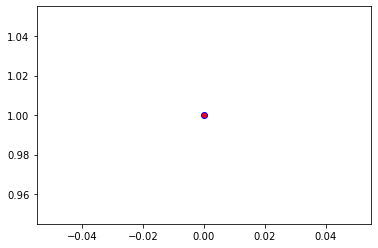

Counter: 456
000000527960 703 = park bench
000000528314 248 = ski
000000528399 461 = plate
000000528524 346 = water buffalo
000000528578 498 = palace
000000528705 850 = teddy
000000528862 176 = gazelle
000000528977 713 = pier
000000528980 879 = umbrella
000000529105 197 = giant schnauzer
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 0.5
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.5], dtype=float32)>)
Model accuracy after perturbation: [0.5]


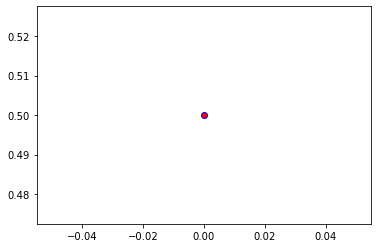

Counter: 457
000000529122 582 = grocery store
000000529148 681 = notebook
000000529528 961 = dough
000000529568 526 = desk
000000529762 762 = restaurant
000000529939 523 = crutch
000000529966 950 = orange
000000530052 932 = pretzel
000000530061 910 = wooden spoon
000000530099 263 = Pembroke
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 1.0
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>)
Model accuracy after perturbation: [1.]


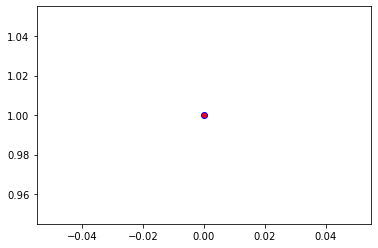

Counter: 458
000000530146 461 = plate
000000530162 568 = fur coat
000000530457 28 = pot
000000530466 829 = streetcar
000000530470 975 = lakeside
000000530624 434 = bath towel
000000530820 981 = ballplayer
000000530836 424 = barbershop
000000530854 750 = quilt
000000530975 934 = hotdog
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 0.800000011920929
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.2], dtype=float32)>)
Model accuracy after perturbation: [0.8]


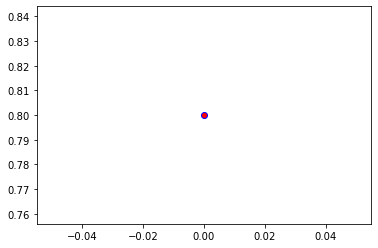

Counter: 459
000000531036 874 = trolleybus
000000531134 920 = traffic light
000000531135 981 = ballplayer
000000531495 536 = dock
000000531707 703 = park bench
000000531771 848 = tape player
000000532058 116 = cradle
000000532071 295 = American black bear
000000532129 963 = pizza
000000532481 701 = parachute
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 0.8999999761581421
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.1], dtype=float32)>)
Model accuracy after perturbation: [0.9]


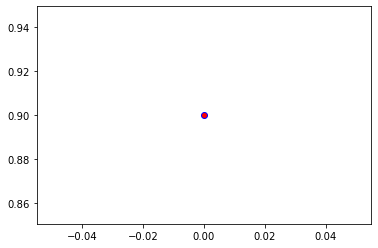

Counter: 460
000000532493 2 = great white shark
000000532530 454 = bookshop
000000532575 225 = malinois
000000532690 608 = jean
000000532761 905 = window shade
000000532855 543 = dumbbell
000000532901 564 = four-poster
000000533145 745 = projector
000000533206 461 = plate
000000533493 747 = punching bag
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 0.8999999761581421
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.1], dtype=float32)>)
Model accuracy after perturbation: [0.9]


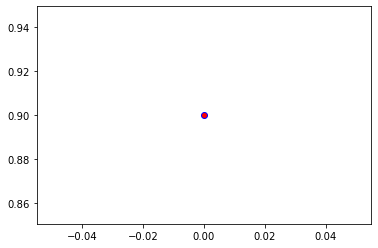

Counter: 461
000000533536 851 = television
000000533816 791 = shopping cart
000000533855 616 = knot
000000533958 461 = plate
000000534041 680 = nipple
000000534270 447 = binoculars
000000534394 385 = Indian elephant
000000534601 850 = teddy
000000534605 802 = snowmobile
000000534639 829 = streetcar
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 0.8999999761581421
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.1], dtype=float32)>)
Model accuracy after perturbation: [0.9]


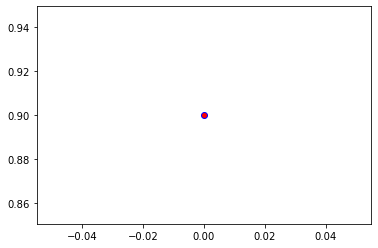

Counter: 462
000000534664 597 = holster
000000534673 705 = passenger car
000000534827 665 = moped
000000535094 178 = Weimaraner
000000535156 385 = Indian elephant
000000535253 865 = toyshop
000000535306 491 = chain saw
000000535523 550 = espresso maker
000000535578 5 = ram
000000535608 977 = sandbar
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 0.8999999761581421
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.1], dtype=float32)>)
Model accuracy after perturbation: [0.9]


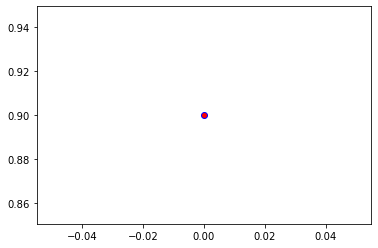

Counter: 463
000000535858 147 = grey whale
000000536038 658 = mitten
000000536073 505 = coffeepot
000000536343 435 = bathtub
000000536947 637 = mailbox
000000537053 9 = ostrich
000000537153 978 = seashore
000000537241 962 = meat loaf
000000537270 314 = cockroach
000000537355 660 = mobile home
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 1.0
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>)
Model accuracy after perturbation: [1.]


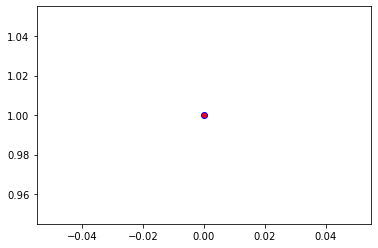

Counter: 464
000000537506 879 = umbrella
000000537672 707 = pay-phone
000000537802 850 = teddy
000000537812 861 = toilet seat
000000537827 981 = ballplayer
000000537964 637 = mailbox
000000537991 650 = microphone
000000538067 671 = mountain bike
000000538236 931 = bagel
000000538364 670 = motor scooter
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 1.0
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>)
Model accuracy after perturbation: [1.]


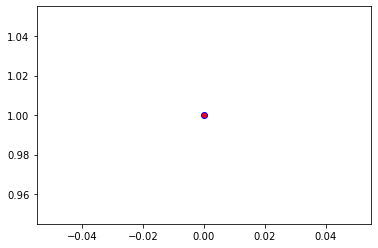

Counter: 465
000000538458 791 = shopping cart
000000539143 547 = electric locomotive
000000539445 547 = electric locomotive
000000539883 664 = monitor
000000539962 713 = pier
000000540280 879 = umbrella
000000540414 582 = grocery store
000000540466 879 = umbrella
000000540502 896 = washbasin
000000540928 361 = skunk
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 0.8999999761581421
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.1], dtype=float32)>)
Model accuracy after perturbation: [0.9]


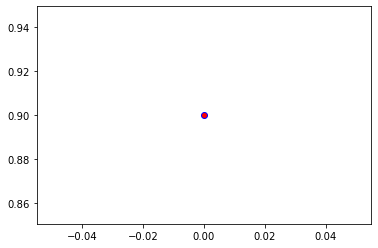

Counter: 466
000000540932 977 = sandbar
000000540962 526 = desk
000000541055 248 = ski
000000541123 781 = scoreboard
000000541291 743 = prison
000000541634 809 = soup bowl
000000541664 613 = joystick
000000541773 882 = vacuum
000000541952 557 = flagpole
000000542073 415 = bakery
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 0.8999999761581421
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.1], dtype=float32)>)
Model accuracy after perturbation: [0.9]


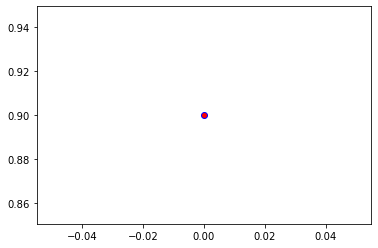

Counter: 467
000000542089 896 = washbasin
000000542127 248 = ski
000000542423 703 = park bench
000000542625 324 = cab
000000542776 158 = toy terrier
000000542856 874 = trolleybus
000000543043 705 = passenger car
000000543047 831 = studio couch
000000543300 536 = dock
000000543528 404 = airliner
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 0.800000011920929
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.2], dtype=float32)>)
Model accuracy after perturbation: [0.8]


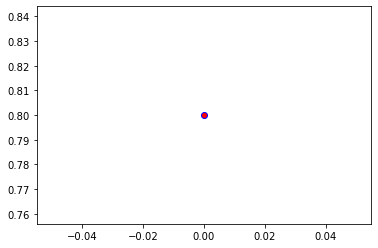

Counter: 468
000000543581 831 = studio couch
000000544052 870 = tricycle
000000544306 497 = church
000000544444 248 = ski
000000544519 419 = Band Aid
000000544565 960 = chocolate sauce
000000544605 919 = street sign
000000544811 144 = pelican
000000545007 708 = pedestal
000000545100 639 = suit
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 0.800000011920929
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.2], dtype=float32)>)
Model accuracy after perturbation: [0.8]


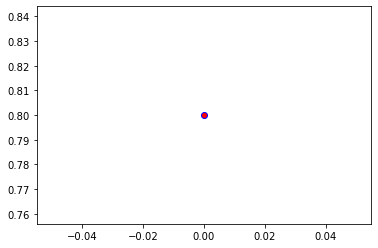

Counter: 469
000000545129 340 = zebra
000000545219 569 = garbage truck
000000545407 318 = wing
000000545594 654 = minibus
000000545730 99 = goose
000000545826 879 = umbrella
000000545958 343 = warthog
000000546011 340 = zebra
000000546219 762 = restaurant
000000546325 831 = studio couch
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 0.8999999761581421
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.1], dtype=float32)>)
Model accuracy after perturbation: [0.9]


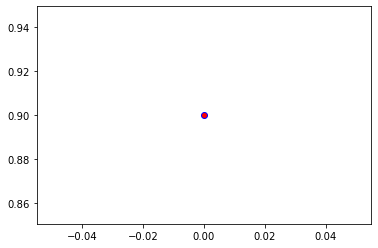

Counter: 470
000000546475 761 = remote control
000000546556 127 = white stork
000000546626 647 = measuring cup
000000546659 547 = electric locomotive
000000546717 611 = jigsaw puzzle
000000546823 873 = triumphal arch
000000546826 473 = can opener
000000546829 202 = soft-coated wheaten terrier
000000546964 762 = restaurant
000000546976 813 = spatula
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 1.0
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>)
Model accuracy after perturbation: [1.]


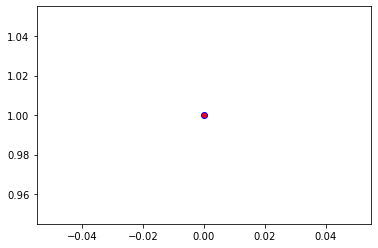

Counter: 471
000000547144 527 = desktop computer
000000547336 620 = laptop
000000547383 5 = ram
000000547502 162 = beagle
000000547519 294 = brown bear
000000547816 794 = shower curtain
000000547854 934 = hotdog
000000547886 354 = Arabian camel
000000548246 752 = racket
000000548267 979 = valley
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 0.8999999761581421
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.1], dtype=float32)>)
Model accuracy after perturbation: [0.9]


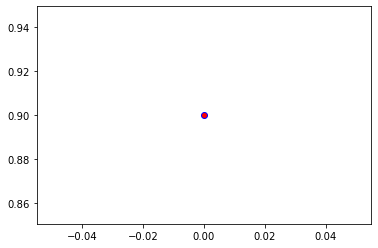

Counter: 472
000000548339 429 = baseball
000000548506 954 = banana
000000548524 460 = breakwater
000000548555 934 = hotdog
000000548780 655 = miniskirt
000000549055 864 = wreck
000000549136 358 = pole
000000549167 461 = plate
000000549220 355 = llama
000000549390 444 = bicycle-built-for-two
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 0.699999988079071
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.3], dtype=float32)>)
Model accuracy after perturbation: [0.7]


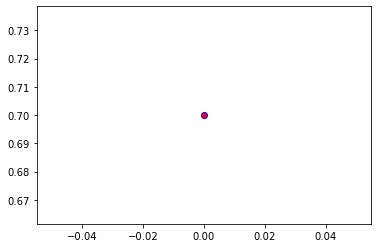

Counter: 473
000000549674 664 = monitor
000000549738 557 = flagpole
000000549930 879 = umbrella
000000550084 864 = tow truck
000000550322 473 = can opener
000000550349 625 = lifeboat
000000550426 883 = vase
000000550471 950 = orange
000000550691 874 = trolleybus
000000550714 954 = banana
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 1.0
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>)
Model accuracy after perturbation: [1.]


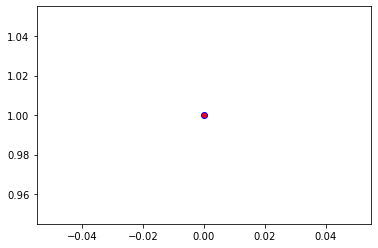

Counter: 474
000000550797 861 = toilet seat
000000550939 919 = street sign
000000551215 805 = soccer ball
000000551304 861 = toilet seat
000000551350 703 = park bench
000000551439 617 = lab coat
000000551660 937 = broccoli
000000551780 409 = analog clock
000000551794 665 = moped
000000551804 752 = racket
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 1.0
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>)
Model accuracy after perturbation: [1.]


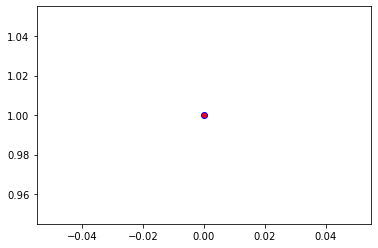

Counter: 475
000000551815 287 = lynx
000000551820 890 = volleyball
000000551822 960 = chocolate sauce
000000552371 339 = sorrel
000000552612 54 = hog
000000552775 827 = stove
000000552842 981 = ballplayer
000000552883 651 = microwave
000000552902 340 = zebra
000000553094 895 = warplane
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 0.8999999761581421
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.1], dtype=float32)>)
Model accuracy after perturbation: [0.9]


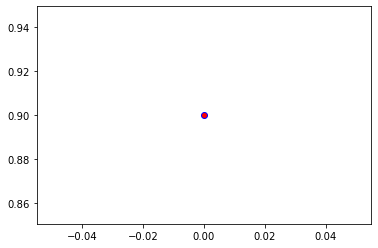

Counter: 476
000000553221 701 = parachute
000000553339 358 = pole
000000553511 920 = traffic light
000000553664 526 = desk
000000553669 703 = park bench
000000553731 731 = plunger
000000553776 670 = motor scooter
000000553788 681 = notebook
000000553990 339 = sorrel
000000554002 233 = Bouvier des Flandres
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 0.8999999761581421
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.1], dtype=float32)>)
Model accuracy after perturbation: [0.9]


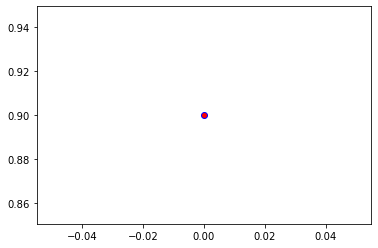

Counter: 477
000000554156 752 = racket
000000554266 887 = vestment
000000554291 162 = beagle
000000554328 515 = cowboy hat
000000554579 263 = Pembroke
000000554595 693 = paddle
000000554735 963 = pizza
000000554838 760 = refrigerator
000000555005 435 = bathtub
000000555009 664 = monitor
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 1.0
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>)
Model accuracy after perturbation: [1.]


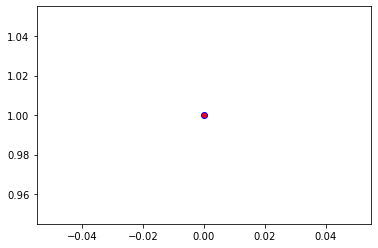

Counter: 478
000000555012 435 = bathtub
000000555050 829 = streetcar
000000555412 934 = hotdog
000000555597 497 = church
000000555705 282 = tiger cat
000000555972 532 = dining table
000000556000 776 = sax
000000556158 248 = ski
000000556193 882 = vacuum
000000556498 919 = street sign
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 0.8999999761581421
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.1], dtype=float32)>)
Model accuracy after perturbation: [0.9]


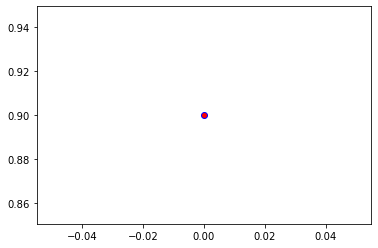

Counter: 479
000000556765 385 = Indian elephant
000000556873 835 = sundial
000000557172 896 = washbasin
000000557258 861 = toilet seat
000000557501 840 = swab
000000557672 879 = umbrella
000000557884 883 = vase
000000557916 116 = cradle
000000558073 435 = tub
000000558114 430 = basketball
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 0.800000011920929
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.2], dtype=float32)>)
Model accuracy after perturbation: [0.8]


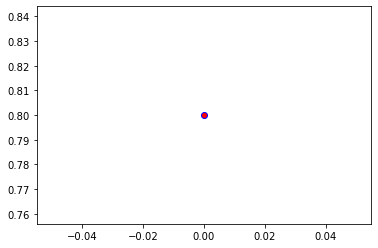

Counter: 480
000000558213 471 = cannon
000000558421 705 = passenger car
000000558558 920 = traffic light
000000558854 933 = cheeseburger
000000559099 37 = ox
000000559160 416 = balance beam
000000559348 981 = ballplayer
000000559513 461 = plate
000000559543 496 = Christmas stocking
000000559547 715 = pickelhaube
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 0.800000011920929
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.2], dtype=float32)>)
Model accuracy after perturbation: [0.8]


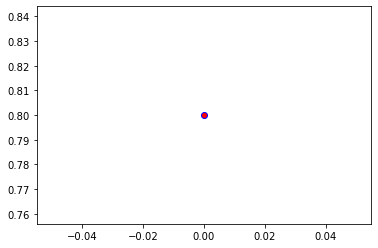

Counter: 481
000000559707 937 = broccoli
000000559842 805 = soccer ball
000000559956 5 = ram
000000560011 673 = mouse
000000560178 41 = hip
000000560256 954 = banana
000000560266 294 = brown bear
000000560279 896 = washbasin
000000560312 743 = prison
000000560371 919 = street sign
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 0.800000011920929
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.2], dtype=float32)>)
Model accuracy after perturbation: [0.8]


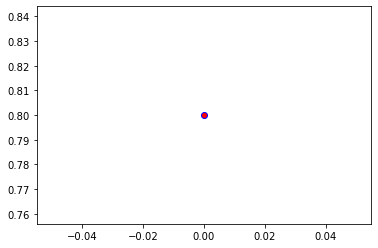

Counter: 482
000000560474 582 = grocery store
000000560880 471 = cannon
000000560911 457 = bow tie
000000561009 16 = bulbul
000000561223 842 = swimming trunks
000000561256 400 = gown
000000561335 472 = canoe
000000561366 673 = mouse
000000561465 962 = meat loaf
000000561679 919 = street sign
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 0.8999999761581421
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.1], dtype=float32)>)
Model accuracy after perturbation: [0.9]


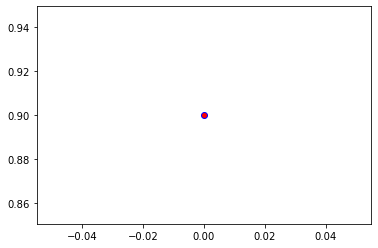

Counter: 483
000000561889 461 = plate
000000561958 248 = ski
000000562059 910 = wooden spoon
000000562121 340 = zebra
000000562197 937 = broccoli
000000562207 101 = tusker
000000562229 248 = ski
000000562243 906 = Windsor tie
000000562443 340 = zebra
000000562448 874 = trolleybus
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 0.699999988079071
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.3], dtype=float32)>)
Model accuracy after perturbation: [0.7]


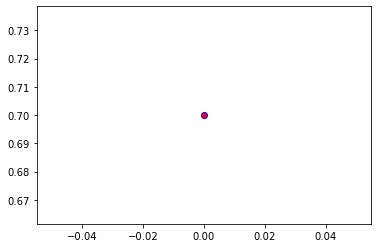

Counter: 484
000000562561 250 = Siberian husky
000000562581 722 = ping-pong ball
000000562818 140 = alp
000000562843 504 = coffee mug
000000563267 775 = sarong
000000563281 496 = Christmas stocking
000000563349 701 = parachute
000000563470 702 = parallel bars
000000563603 138 = bustard
000000563604 920 = traffic light
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 0.8999999761581421
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.1], dtype=float32)>)
Model accuracy after perturbation: [0.9]


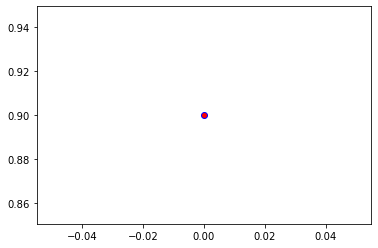

Counter: 485
000000563648 491 = chain saw
000000563653 920 = traffic light
000000563702 555 = fire engine
000000563758 191 = Airedale
000000563882 761 = remote control
000000564023 632 = loudspeaker
000000564091 611 = jigsaw puzzle
000000564127 861 = toilet seat
000000564133 101 = tusker
000000564280 172 = whippet
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 1.0
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>)
Model accuracy after perturbation: [1.]


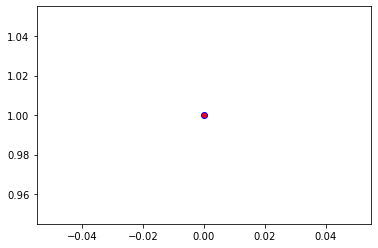

Counter: 486
000000564336 822 = steel drum
000000565012 829 = streetcar
000000565045 894 = wardrobe
000000565153 919 = street sign
000000565391 609 = jeep
000000565469 442 = bell cote
000000565563 704 = parking meter
000000565597 963 = pizza
000000565607 898 = water bottle
000000565624 385 = Indian elephant
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 1.0
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>)
Model accuracy after perturbation: [1.]


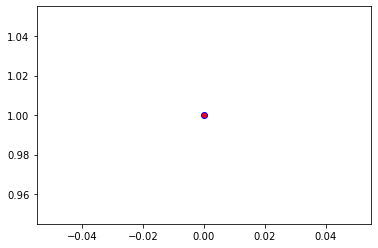

Counter: 487
000000565776 651 = microwave
000000565778 705 = passenger car
000000565853 598 = home theater
000000565877 681 = notebook
000000565962 715 = pickelhaube
000000565989 442 = bell cote
000000566042 172 = whippet
000000566282 880 = unicycle
000000566436 703 = park bench
000000566524 705 = passenger car
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 1.0
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>)
Model accuracy after perturbation: [1.]


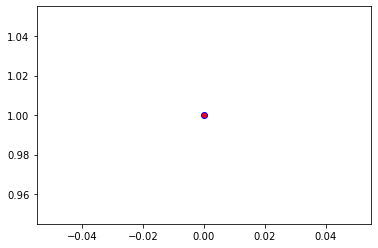

Counter: 488
000000566758 779 = school bus
000000566923 830 = stretcher
000000567011 814 = speedboat
000000567197 498 = cinema
000000567432 318 = wing
000000567640 805 = soccer ball
000000567740 248 = ski
000000567825 933 = cheeseburger
000000567886 850 = teddy
000000567898 712 = Petri dish
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 0.800000011920929
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.2], dtype=float32)>)
Model accuracy after perturbation: [0.8]


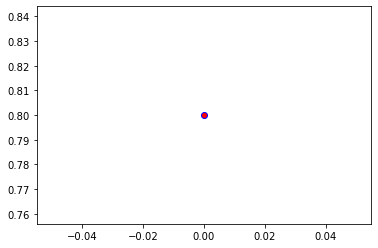

Counter: 489
000000568147 704 = parking meter
000000568195 809 = soup bowl
000000568213 805 = soccer ball
000000568290 874 = trolleybus
000000568439 829 = streetcar
000000568584 564 = four-poster
000000568690 861 = toilet seat
000000568710 811 = space heater
000000568814 784 = screwdriver
000000568981 615 = knee pad
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 1.0
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>)
Model accuracy after perturbation: [1.]


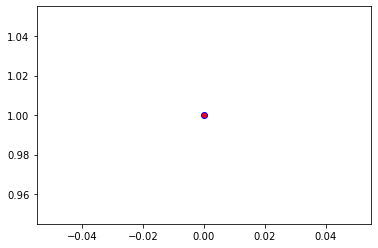

Counter: 490
000000569030 920 = traffic light
000000569059 526 = desk
000000569273 637 = mailbox
000000569565 779 = school bus
000000569700 883 = vase
000000569825 981 = ballplayer
000000569917 648 = medicine chest
000000569972 693 = paddle
000000569976 398 = abacus
000000570169 767 = rubber eraser
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 1.0
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>)
Model accuracy after perturbation: [1.]


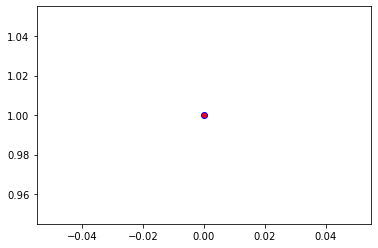

Counter: 491
000000570448 724 = pirate
000000570456 651 = microwave
000000570471 582 = grocery store
000000570539 865 = toyshop
000000570664 282 = tiger cat
000000570688 701 = parachute
000000570736 435 = bathtub
000000570756 978 = seashore
000000570782 527 = desktop computer
000000570834 671 = mountain bike
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 1.0
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>)
Model accuracy after perturbation: [1.]


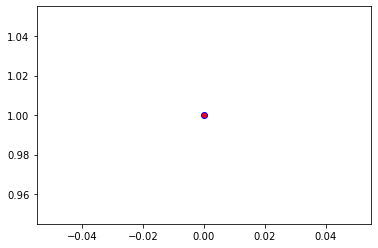

Counter: 492
000000571008 919 = street sign
000000571264 665 = moped
000000571313 453 = bookcase
000000571598 457 = bow tie
000000571718 954 = banana
000000571804 861 = toilet seat
000000571857 977 = sandbar
000000571893 579 = grand piano
000000571943 821 = steel arch bridge
000000572303 565 = freight car
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 1.0
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>)
Model accuracy after perturbation: [1.]


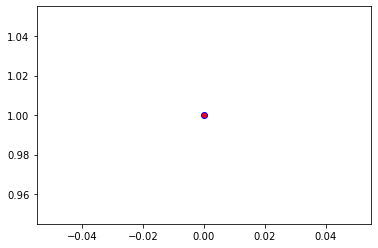

Counter: 493
000000572388 722 = ping-pong ball
000000572408 184 = Irish terrier
000000572462 829 = streetcar
000000572517 296 = ice bear
000000572555 547 = electric locomotive
000000572620 880 = unicycle
000000572678 762 = restaurant
000000572900 480 = cash machine
000000572956 670 = motor scooter
000000573008 460 = breakwater
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 1.0
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>)
Model accuracy after perturbation: [1.]


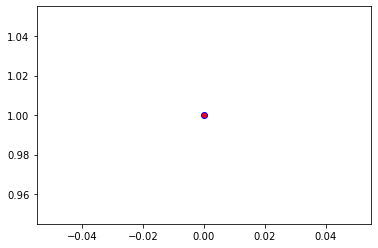

Counter: 494
000000573094 495 = china cabinet
000000573258 248 = ski
000000573391 342 = wild boar
000000573626 979 = valley
000000573943 582 = grocery store
000000574297 339 = sorrel
000000574315 281 = tabby
000000574425 864 = tow truck
000000574520 693 = paddle
000000574702 665 = moped
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 0.8999999761581421
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.1], dtype=float32)>)
Model accuracy after perturbation: [0.9]


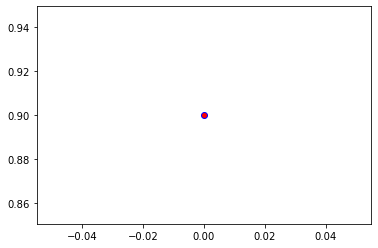

Counter: 495
000000574810 283 = Persian cat
000000574823 981 = ballplayer
000000575081 840 = swab
000000575187 150 = sea lion
000000575205 318 = wing
000000575243 576 = gondola
000000575357 184 = Irish terrier
000000575372 920 = traffic light
000000575500 954 = banana
000000575815 963 = pizza
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 0.8999999761581421
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.1], dtype=float32)>)
Model accuracy after perturbation: [0.9]


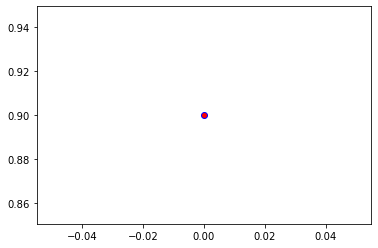

Counter: 496
000000575970 532 = dining table
000000576031 248 = ski
000000576052 140 = alp
000000576566 880 = unicycle
000000576654 701 = parachute
000000576955 562 = fountain
000000577149 340 = zebra
000000577182 703 = park bench
000000577539 928 = ice cream
000000577584 651 = microwave
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 0.800000011920929
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.2], dtype=float32)>)
Model accuracy after perturbation: [0.8]


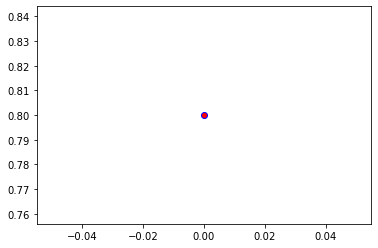

Counter: 497
000000577735 539 = doormat
000000577862 288 = leopard
000000577864 805 = soccer ball
000000577932 880 = unicycle
000000577959 977 = sandbar
000000577976 920 = traffic light
000000578093 705 = passenger car
000000578236 435 = bathtub
000000578489 831 = studio couch
000000578500 762 = restaurant
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 1.0
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>)
Model accuracy after perturbation: [1.]


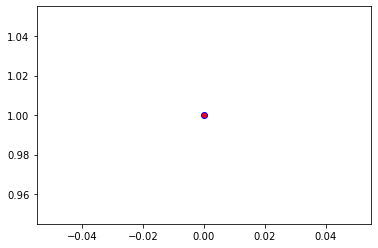

Counter: 498
000000578545 697 = pajama
000000578792 518 = crash helmet
000000578871 461 = plate
000000578922 883 = vase
000000578967 705 = passenger car
000000579070 720 = pill bottle
000000579091 937 = broccoli
000000579158 404 = airliner
000000579307 977 = sandbar
000000579321 201 = silky terrier
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 0.8999999761581421
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.1], dtype=float32)>)
Model accuracy after perturbation: [0.9]


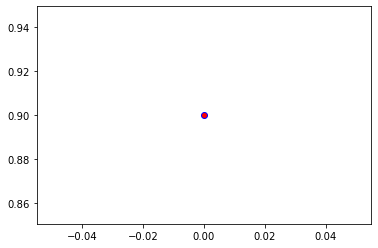

Counter: 499
000000579635 814 = speedboat
000000579655 678 = neck brace
000000579818 820 = steam locomotive
000000579893 919 = street sign
000000579900 963 = pizza
000000579902 518 = crash helmet
000000579970 799 = sliding door
000000580197 457 = bow tie
000000580294 909 = wok
000000580410 453 = bookcase
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 1.0
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>)
Model accuracy after perturbation: [1.]


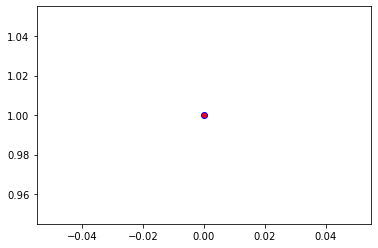

Counter: 500
000000580418 37 = ox
000000580757 704 = parking meter
000000581062 792 = shovel
000000581100 355 = llama
000000581206 934 = hotdog
000000581317 596 = hatchet
000000581357 248 = ski
000000581482 409 = analog clock
000000581615 861 = toilet seat
000000581781 954 = banana
Min values in image-array: -1.0 Max values in image-array: 1.0
Min values in image-array: 0.0 Max values in image-array: 1.0
Model accuracy on own images: 0.800000011920929
L2CarliniWagnerAttack(binary_search_steps=5, steps=100, stepsize=0.001, confidence=0, initial_const=0.01, abort_early=True)
TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.2], dtype=float32)>)
Model accuracy after perturbation: [0.8]


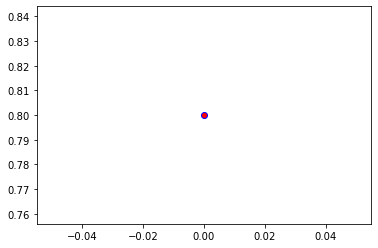

In [13]:
# Creates figure object containing image, class and class confidence
class MyFigure:
    def __init__(self, image , image_class, class_confidence):
        self.image = image
        self.image_class = image_class
        self.class_confidence = class_confidence

# instantiate the corresponding attack class
def attack_type(attack):
    if attack == 'LinfPGD':
        return fb.attacks.LinfProjectedGradientDescentAttack()
    elif attack == 'FGSM':
        return fb.attacks.LinfFastGradientAttack()
    elif attack == 'CW_L2':
        return fb.attacks.L2CarliniWagnerAttack(steps=100, binary_search_steps=5, initial_const=0.01,stepsize=0.001, abort_early=True)
    elif attack == 'DeepFool':
        return fb.attacks.L2DeepFoolAttack()
    else:
        print('Select valid attack')     

# divide files into successive n-sized chunks.
def divide_chunks(l, n):
    # looping till length l
    for i in range(0, len(l), n): 
        yield l[i:i + n]

# Save images
def save_images(images):
    for x in range(0, len(images)):
        _, image_class, class_confidence = get_imagenet_label(image_probs)
        name = original_name[x]
        try:
            plt.imsave('adv_data_cw/{}.jpg'.format(original_name[x]), images[x].image)
        except:
            print('ERROR while saving')
        
# load images into a list
list_images = glob.glob('datasets/coco_original/data/*.jpg')

# size of batches that are created from list of images
n = 10
batches = list(divide_chunks(list_images, n))
counter = 0

#steps = 10
#epsilons = np.linspace(0.0, 0.10, num=steps)
epsilons = [0]
attacks = ['LinfPGD',
          'FGSM',
          'CW_L2',
          'DeepFool']
attack = attack_type(attacks[2])

# for each batch do following steps
# 1: Process image and get original image name and predict class for image.
# 2: Convert the image pixel values and labels for foolbox approved type
# 3: Create attack
# 4: Save crafted images into folder

for batch in batches:
    own_images = [] #preprocessed images
    image_probabilities = []
    image_ids = []
    original_name = []
    counter += 1
    print('Counter:', counter)

    for fname in batch:
        image_name = fname.split('\\')[1].split('.').pop(0)
        original_name.append(image_name)
        image_raw = tf.io.read_file(fname)
        image = tf.image.decode_image(image_raw)
        image = preprocess(image)
        own_images.append(image)
        image_probs = pretrained_model.predict(image)
        image_probabilities.append(image_probs)
    if path.exists('adv_data_cw/{}'.format(image_name) + '.jpg'):
        print('Adversarial file exists')
        continue
    for x, y, name in zip(own_images, image_probabilities, original_name):
        #plt.figure()
        #plt.imshow(x[0] * 0.5 + 0.5)  # To change [-1, 1] to [0,1]?
        _, image_class, class_confidence = get_imagenet_label(y)
        image_class = image_class.replace("_", " ")
        print(name, str(find_label_id(image_class)) + ' = ' + image_class) # if none error incurs later
        image_ids.append(find_label_id(image_class))
        #plt.title('{} : {:.2f}% Confidence'.format(image_class, class_confidence*100))
        #plt.close()

    # Prints values of pixels
    print('Min values in image-array: ' + str(np.amin(own_images)) + ' Max values in image-array: ' + str(np.amax(own_images)))
    #Convert own images and corresponding labels for foolbox approved type
    own_images_tf = []
    own_labels_tf = tf.convert_to_tensor(image_ids, dtype=tf.int32)
    for x in own_images.copy():
        a = tf.squeeze(x)
        a = (a + 1.0)/2 # shift from [-1,1] to [0,1] with 0.5 mean
        own_images_tf.append(a)
    own_images_tf = tf.convert_to_tensor(own_images_tf, dtype=tf.float32)
    # Prints values of pixels after processing
    print('Min values in image-array: ' + str(np.amin(own_images_tf)) + ' Max values in image-array: ' + str(np.amax(own_images_tf)))
    # Testing that conversion works
    #fb.plot.images(own_images_tf)
    accuracy = fb.utils.accuracy(fmodel, own_images_tf, own_labels_tf)
    print('Model accuracy on own images:', accuracy)

    # use eagerpy tensors own images
    images = ep.astensor(own_images_tf)
    labels = ep.astensor(own_labels_tf)
    # all are tensors
    # raw = The raw adversarial examples. --> depends on attack
    # clipped = The clipped adversarial examples --> guaranteed to not be perturbed more than epsilon.
    # is_adv = boolean for each sample image. True if misclassified and within the epsilon balls around the clean sample.
    print(attack)
    raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=epsilons)
    print(is_adv.float32().mean(axis=-1))
    robust_accuracy = 1 - is_adv.float32().mean(axis=-1)
    # show accuracy vs epsilons
    print('Model accuracy after perturbation:', robust_accuracy.numpy())
    plt.plot(epsilons, robust_accuracy.numpy(), color='blue', linestyle='solid', marker='o', markerfacecolor='red')
    plt.show()
    plt.close()

    for perturbed_step, epsilon in zip(clipped, epsilons):
        list_of_figures = []

        for x in perturbed_step:
            x = x.numpy()
            image = np.expand_dims(x, axis=0)
            image_probs = pretrained_model.predict(image)
            _, image_class, class_confidence = get_imagenet_label(image_probs)       

            #create fig object
            a = MyFigure(x, image_class, class_confidence)
            list_of_figures.append(a)

        save_images(list_of_figures)

Epsilon value of adversary: 0


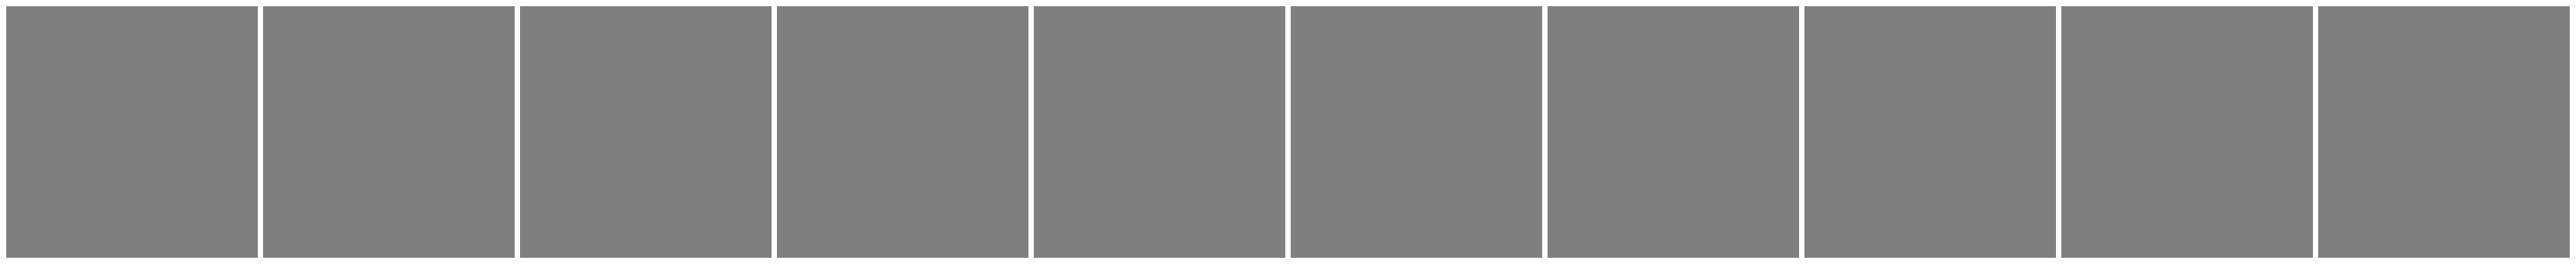

In [14]:
# show adversary
for adversary, epsilon in zip(clipped, epsilons):
    print('Epsilon value of adversary:', str(epsilon))
    fb.plot.images(adversary - images, bounds=(-0.1, 0.1), scale=4.)
    plt.show()
    plt.close()

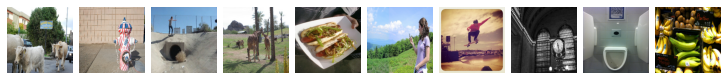

In [15]:
# show adversarial images using fb.plot
for adversary in clipped:
    fb.plot.images(adversary)
    plt.show()
    plt.close()

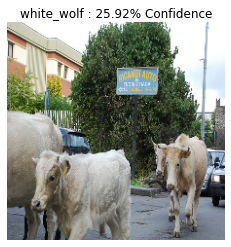

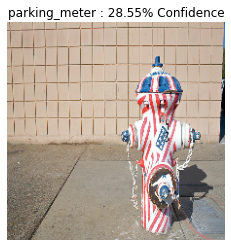

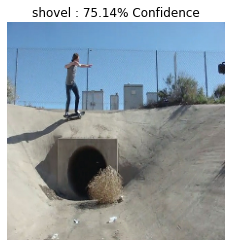

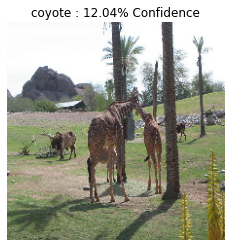

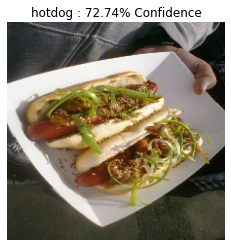

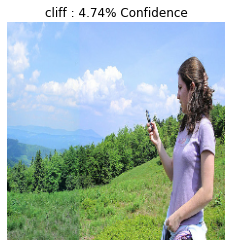

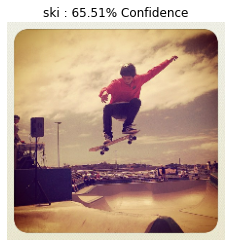

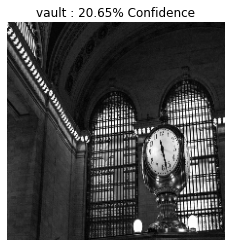

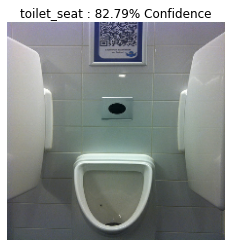

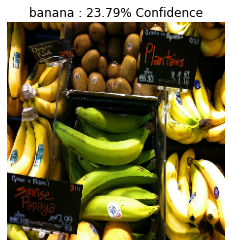

In [16]:
# helper variables for visualizing only one image
row_number = 0 # 0-len(epsilon)

clipped_adversarial_images = clipped[row_number].numpy()

# Predict adversarial image and show visualization
for x in clipped_adversarial_images:
    image = np.expand_dims(x, axis=0)
    image_probs = pretrained_model.predict(image)
    plt.figure()
    plt.imshow(x)  # To change [-1, 1] to [0,1] #  * 0.5 + 0.2
    _, image_class, class_confidence = get_imagenet_label(image_probs)
    plt.title('{} : {:.2f}% Confidence'.format(image_class, class_confidence*100))
    plt.axis('off')
    plt.show()